# Notebook 70: To Make a Peak

In [16]:
nb_id = 70

How does a peak emerge from CHE? Within the space of reasonable physical assumptions, does CHE always produce a peak? What is the range of positions that peak can occupy? What must be true in order for that position to be $35\,\mathrm{M}_\odot$?

#### Setup

In [256]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import CubicSpline

import sys
sys.path.append('..')
from src.util import (savefig_base, DATA_DIR, NB_OUTPUT_DIR, Z_SUN)

plt.style.use('plotstyle.mplstyle')

In [18]:
FIGURE_FOLDER = NB_OUTPUT_DIR / f'nb{nb_id:02d}/plots'
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)
def savefig(*args, **kwargs): 
    savefig_base(*args, nb_id=nb_id, figure_folder=FIGURE_FOLDER, **kwargs)

## An analytical thick wind model

Say that, for each stage $S$ of stellar evolution, the duration of that stage, or its lifetime, is given by

$$
\begin{equation}
\tau_S = \tau_r \left(\frac{M_i}{M_r}\right)^{-\alpha_S},
\end{equation}
$$

where $M_i$ is the stellar mass at the beginning of $S$, $M_r$ is an arbitrary reference mass, $\tau_r$ the duration of stage $S$ for a star of mass $M_r$, and $\alpha_S>0$. Say also that the mass loss rate during stage $S$ is given by

$$
\dot{M}_S = \dot{M}_{r,S} \left(\frac{Z}{\mathrm{Z}_\odot}\right)^{\gamma_S} \left(\frac{M}{M_r}\right)^{\beta_S},
$$

where $\dot{M}_{r,S}$ is the mass loss rate for a star of mass $M_r$ at $\mathrm{Z}_\odot$, and $\gamma_S, \beta_S>0$. From this, we have a practical definition of $S$ as a stage of stellar evolution characterized by a fixed power-law mass-loss rate, to some reasonable approximation. For fixed metallicity, the balance between $\alpha$ and $\beta$ determines the total mass loss during $S$: more massive stars have both longer lifetimes and greater mass loss rates, and the total mass loss is not necessarily monotonic with initial mass. To evaluate this balance, we can use the two equations to integrate $\dot{M}_S$ over $\tau_S$. Suppressing $S$ for clarity, we have

$$
m_f^{-(\beta-1)} = m_i^{-(\beta-1)} + (\beta-1) \dot{m}_r \zeta^{\gamma} m_i^{-\alpha},
$$

where we $m_i$ and $m_f$ are the initial and final masses during $S$, respectively, and we use dimensionless quantities $m:=M/M_r$, $\dot{m}:=\dot{M}/(M_r \tau_r^{-1})$ and $\zeta=Z/\mathrm{Z}_\odot$. From the onset, we have four major variables: $\dot{M}_r$, $\alpha$, $\beta$ and $\gamma$. Let us start by looking at the initial-final mass mapping for a few different values.

In [225]:
def mf(M_i, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r):
    m_i = M_i/M_r
    mdot_r = Mdot_r / (M_r / tau_r)
    zeta = Z / Z_SUN
    
    m_f_pwr = (
        m_i**(1-beta)
        - (1-beta) * mdot_r * zeta**gamma * m_i**-alpha
    )
    M_f = m_f_pwr**(1/(1-beta)) * M_r
    return M_f

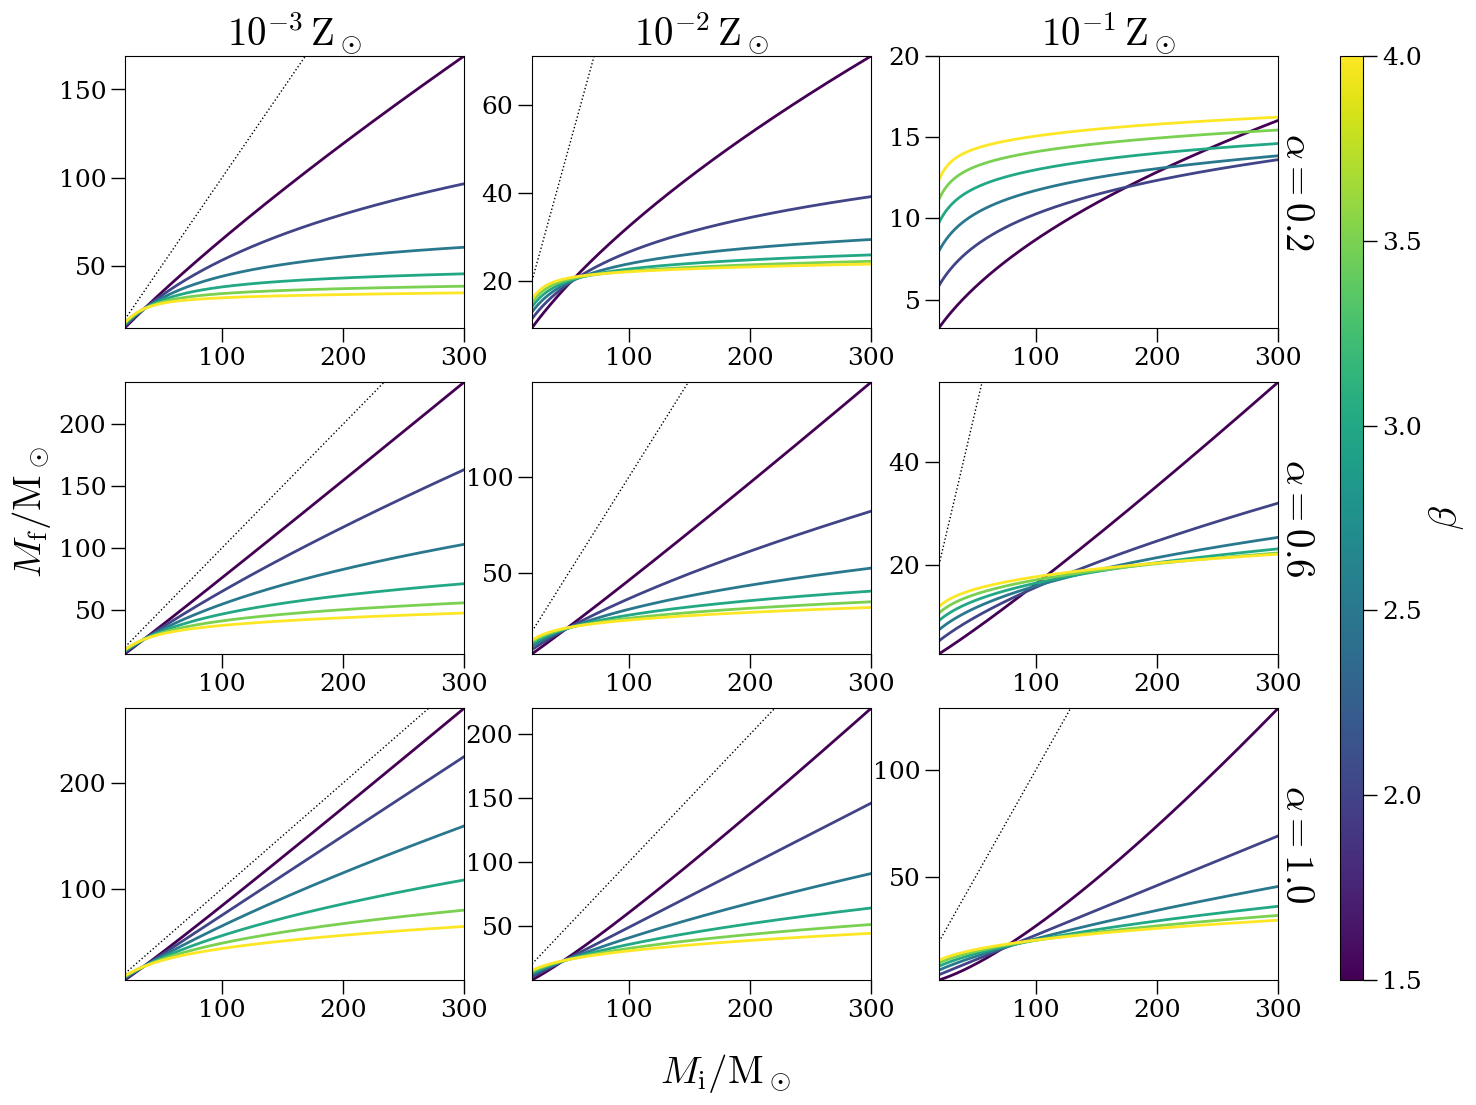

In [20]:
x_min = 20
x_max = 300
m_i_arr = np.linspace(x_min, x_max, 1000)
Z_arr = Z_SUN * 10.**np.arange(-3, 0, 1)
beta_arr = np.arange(1.5, 4.5, 0.5)
alpha_arr = np.arange(0.2, 1.4, 0.4)
gamma = 0.5
M_r = 30
tau_r = 1e6
Mdot_r = 1e-4
cmap = cm.viridis

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, alpha in enumerate(alpha_arr):
    for j, Z in enumerate(Z_arr):
        ax = axes[i, j]
        
        y_min = x_max
        y_max = x_min
        for k, beta in enumerate(beta_arr):
            c = cmap((beta-beta_arr.min()) / (beta_arr.max() - beta_arr.min()))
            y_arr = mf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)
            ax.plot(m_i_arr, y_arr, label=f'β={beta:.1f}', c=c)
            y_min = min(y_min, y_arr.min())
            y_max = max(y_max, y_arr.max())
        
        if i == 0:
            ax.set_title(f'$10^{{{np.log10(Z/Z_SUN):.0f}}}\\,\\mathrm{{Z}}_\\odot$')
        
        if j == len(Z_arr)-1:
            ax.text(1, 0.5, f'$\\alpha={alpha:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
            
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.plot(m_i_arr, m_i_arr, ':', c='k', lw=1)

fig.text(0.08, 0.5, '$M_\\mathrm{f}/\\mathrm{M}_\\odot$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{i}/\\mathrm{M}_\\odot$', rotation=0, ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=beta_arr.min(), vmax=beta_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('$\\beta$')

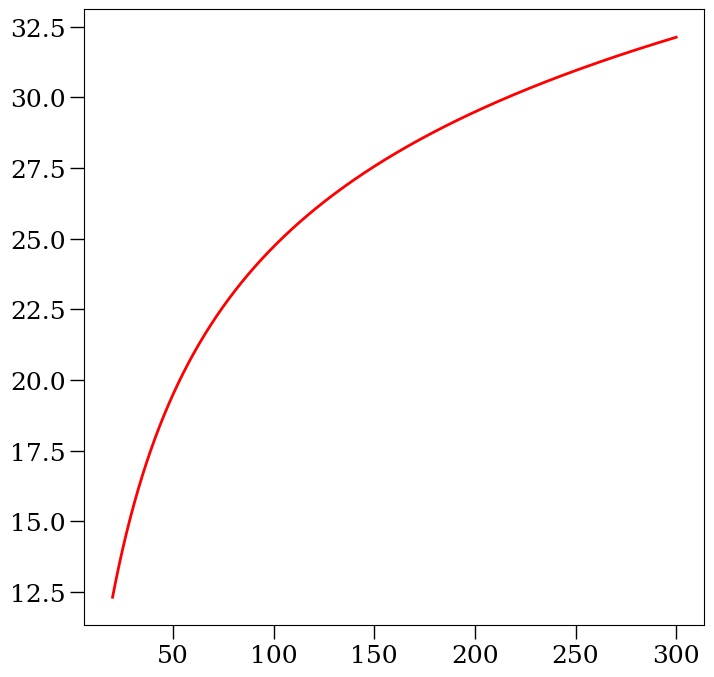

In [372]:
x_min = 20
x_max = 300
m_i_arr = np.linspace(x_min, x_max, 1000)
Z_arr = Z_SUN * 0.1
beta_arr = np.arange(1.5, 4.5, 0.5)
alpha_arr = 0.2
gamma = 0.5
M_r = 30
tau_r = 1e6
Mdot_r = 1e-4
cmap = cm.viridis

fig, ax = plt.subplots(figsize=(8, 8))

Mdot_r = 10.**-4.5
beta =  2.3
y_arr = mf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)
ax.plot(m_i_arr, y_arr, label=f'β={beta:.1f}', c='r')

It is evident that there are several configurations for which a mass pileup could be expected: anytime the initial-final mass flattens, a wide range of initial masses is being mapped to a narrow range of final masses, which will inevitably produce a pileup. How prominent this pileup will be, however, depends on how initial masses are sampled: if they are uncommon, than the pileup might be very modest and not dominate the distribution. Because we know lower masses are heavily favored by the IMF, and because more massive stars, with stronger mass loss, favor piling-up, a prominent pile-up in the final mass distribution might required fine-tuning.

From the plot above, we notice the dominant relation setting the creation of a final mass pile-up is that $\beta>\alpha+A$, to some excess $A$. This is required for massive stars to be able to move to lower masses within their lifetimes; but also for lower masses to have small enough mass loss rates to not decrease any further, even within the longer lifetime of a born-"low-mass" star. In other words, a final mass pile-up is a consequence of 

**Condititon 1: $\beta>\alpha+A$, or a mass-loss rate mass-scaling that is significantly steeper than the lifetime mass-scaling.**

While that condition is necessary, it is not sufficient. If the baseline mass-loss rate is too low, the most massive stars will never have enough time to pile-up at lower masses. We might guess that a "strong enough" baseline mass-loss rate, at fixed metallicity, is some appreciable fraction $\mu$ of the "critical" rate $M_r/\tau_r$, i.e., the constant mass-loss rate that would completely blow away a star of mass $M_r$ within the duration of $S$. Our next condition is then,

**Condition 2: $\dot{M}_r\zeta^\gamma>\mu M_r/\tau_r$, or a baseline mass-loss rate that is a significant fraction of the critical mass-loss rate.**

Condition 2 implies that only some metallicities will ever produce a pileup, unless $\dot{M}_r$ itself is extremely high. Our parameters are evidently degenerate. Increasing $\dot{M}_r$, for example, always loosens the requirements on $\beta$, for fixed $\alpha$, and on $\gamma$. Further constraints might lift it; for example, that on the initial mass sampling.

Assume now that $M_i$ follows a Kroupa IMF. Accounting only for massive stars,

$$\begin{equation}
\frac{\mathrm{d}N}{\mathrm{d}m_i} \propto m_i^{-2.3}
\end{equation}$$

In [21]:
def dn_dmi(M_i):
    return M_i**-2.3

In order to find the resulting $M_f$ distribution, we derivate our previous initial-final mass map, finding

$$
\begin{equation}
\frac{\mathrm{d}m_i}{\mathrm{d}m_f} = \frac{(m_i/m_f)^\beta}{
    1 + \alpha \dot{m}_r \zeta^\gamma (m_i/m_f)^{\beta-(1+\alpha)}
    }
\end{equation}
$$

In [224]:
def dmi_dmf(M_i, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r):
    M_f = mf(M_i, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)
    m_i = M_i / M_r
    m_f = M_f / M_r
    mdot_r = Mdot_r / (M_r / tau_r)
    zeta = Z / Z_SUN
    
    der = (
        (m_i/m_f)**beta
        / (1 + alpha * mdot_r * zeta**gamma * (m_i/m_f)**(beta-(1+alpha)))
    )
    
    return der

So that the final mass distribution is simply

$$
\begin{equation}
\frac{\mathrm{d}N}{\mathrm{d}m_f} = \frac{\mathrm{d}m_i}{\mathrm{d}m_f} \frac{\mathrm{d}N}{\mathrm{d}m_i}
\end{equation}
$$

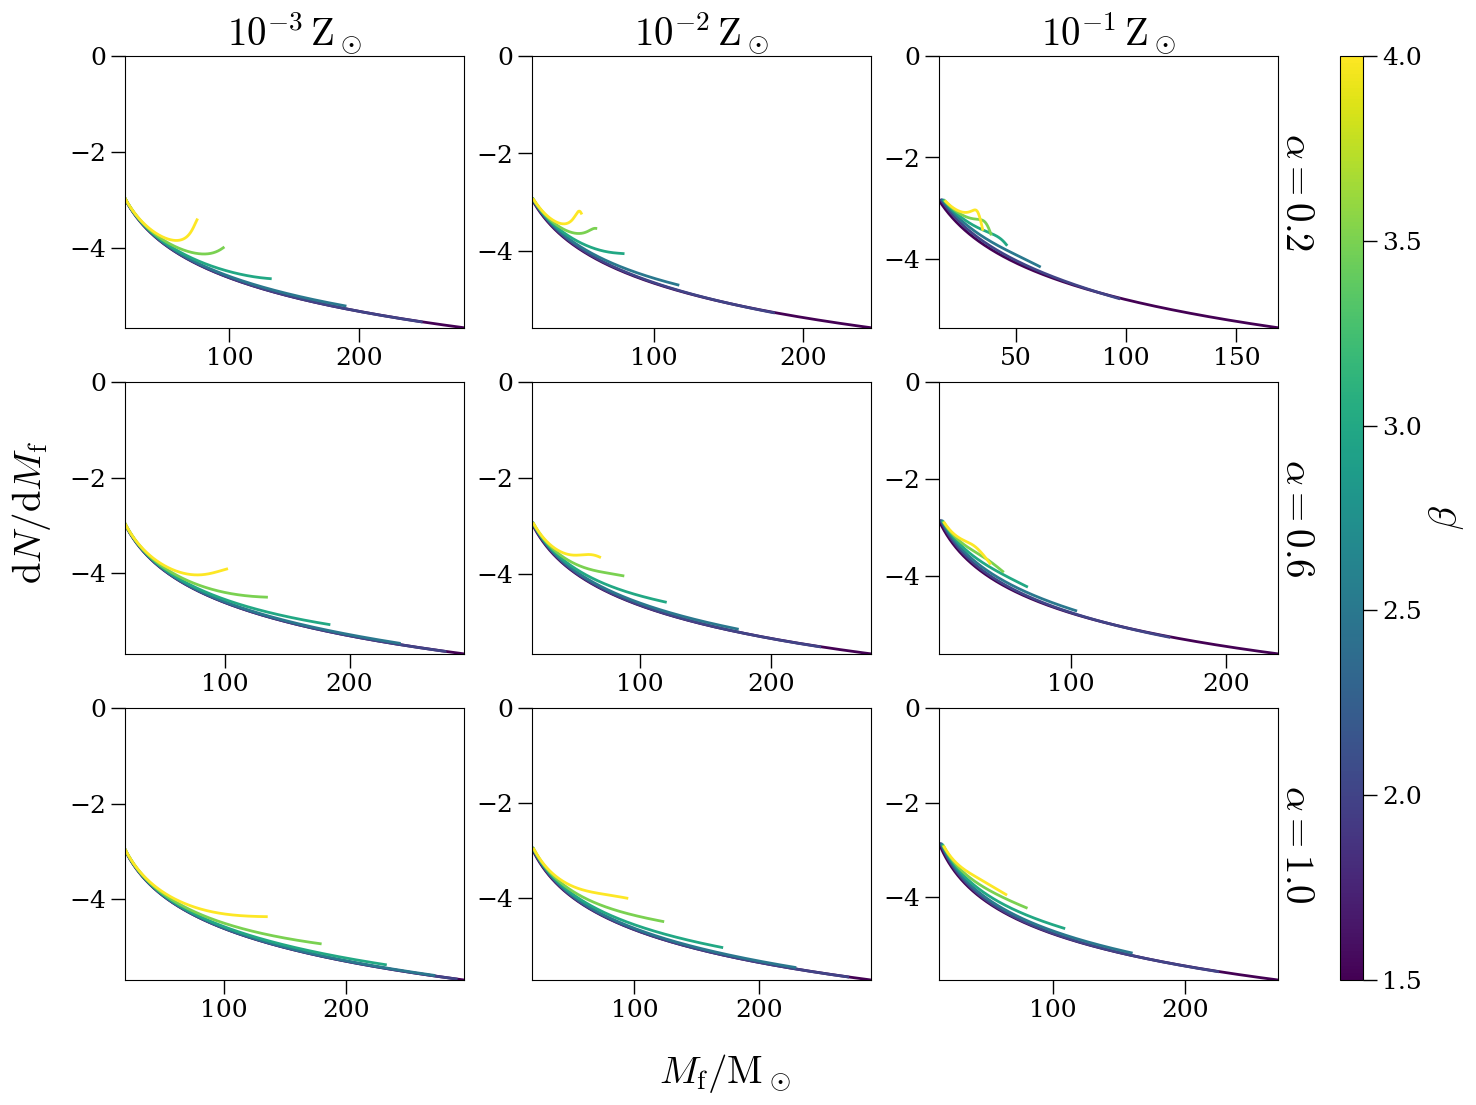

In [23]:
m_i_arr = np.linspace(20, 300, 1000)
Z_arr = Z_SUN * 10.**np.arange(-3, 0, 1)
beta_arr = np.arange(1.5, 4.5, 0.5)
alpha_arr = np.arange(0.2, 1.4, 0.4)
gamma = 0.5
M_r = 30
tau_r = 1e6
Mdot_r = 1e-5
cmap = cm.viridis

fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for i, alpha in enumerate(alpha_arr):
    for j, Z in enumerate(Z_arr):
        ax = axes[i, j]
        
        y_min = np.inf
        y_max = 0
        x_min = np.inf
        x_max = 0
        for k, beta in enumerate(beta_arr):
            c = cmap((beta-beta_arr.min()) / (beta_arr.max() - beta_arr.min()))
            y_arr = np.log10(
                dmi_dmf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r) 
                * dn_dmi(m_i_arr)
            )
            x_arr = mf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)
            ax.plot(x_arr, y_arr, label=f'β={beta:.1f}', c=c)
            y_min = min(y_min, y_arr.min())
            y_max = max(y_max, y_arr.max())
            x_min = min(x_min, x_arr.min())
            x_max = max(x_max, x_arr.max())
        
        if i == 0:
            ax.set_title(f'$10^{{{np.log10(Z/Z_SUN):.0f}}}\\,\\mathrm{{Z}}_\\odot$')
        
        if j == len(Z_arr)-1:
            ax.text(1, 0.5, f'$\\alpha={alpha:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
            
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.plot(m_i_arr, m_i_arr, ':', c='k', lw=1)

fig.text(0.08, 0.5, '$\mathrm{d}N/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{f}/\\mathrm{M}_\\odot$', rotation=0, ha='center', va='top', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=beta_arr.min(), vmax=beta_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('$\\beta$')

As expected, the strong favoring of lower masses by the IMF makes a pronounced pile-up possible only under extreme circumstances, where $\beta\gtrsim\alpha+3.5$. If we are concerned with the contribution from *CHE stars* only, however, we know that the mass axis is severely restricted at the low masses: for CHE there is a lower initial period limit (to avoid L2OF@ZAMS leading into a stellar merger), and an upper initial period limit (to induce rotational mixing through tidal locking), which meet around $\sim20-30\,\mathrm{M}_\odot$, depending on metallicity. We can express the *CHE window* as

$$
\frac{\mathrm{d}N_\mathrm{CHE}}{\mathrm{d}N} = \frac{
    \int_{P_\mathrm{min}(m_i)}^{P_\mathrm{max}(m_i)}\mathrm{d}P\, 
   \frac{\mathrm{d}n}{\mathrm{d}P}}{
    \int_{P_\mathrm{min}(m_i)}^{10^8\,\mathrm{d}}\mathrm{d}P\, 
   \frac{\mathrm{d}n}{\mathrm{d}P}
   },
$$

with an appropriate distribution of birth periods, which we take as Öpik's law,

$$
\frac{\mathrm{d}n}{\mathrm{d}P} \propto \frac{1}{P}
$$

In [ ]:
def dnche_dn(M_i, m_min, p_min, lower_slope, upper_slope):
    lower_intercept = p_min - lower_slope * m_min
    upper_intercept = p_min - upper_slope * m_min
    
    min_che_p = lower_intercept + lower_slope * M_i
    max_che_p = upper_intercept + upper_slope * M_i
    
    dnche_dn = np.log(max_che_p/min_che_p) / np.log(1e8/min_che_p)

    dnche_dn = np.array([dnche_dn]).ravel()
    dnche_dn = np.max((dnche_dn, np.tile(0, len(dnche_dn))), axis=0)
    return dnche_dn


So that the final mass distribution of CHE stars is

$$
\begin{equation}
\frac{\mathrm{d}N_\mathrm{CHE}}{\mathrm{d}m_f} = \frac{\mathrm{d}m_i}{\mathrm{d}m_f}
\overbrace{\frac{\mathrm{d}N_\mathrm{CHE}}{\mathrm{d}N}
 \frac{\mathrm{d}N}{\mathrm{d}m_i}}^{\xi_\mathrm{CHE}},
\end{equation}
$$

where we can naturally define the "CHE star IMF", $\xi_\mathrm{CHE}$.

In [25]:
@np.vectorize
def safe_log10(x):
    if np.isinf(x) or x == 0.:
        return np.nan
    else:
        return np.log10(x)

It is instructive to look at some extreme cases.

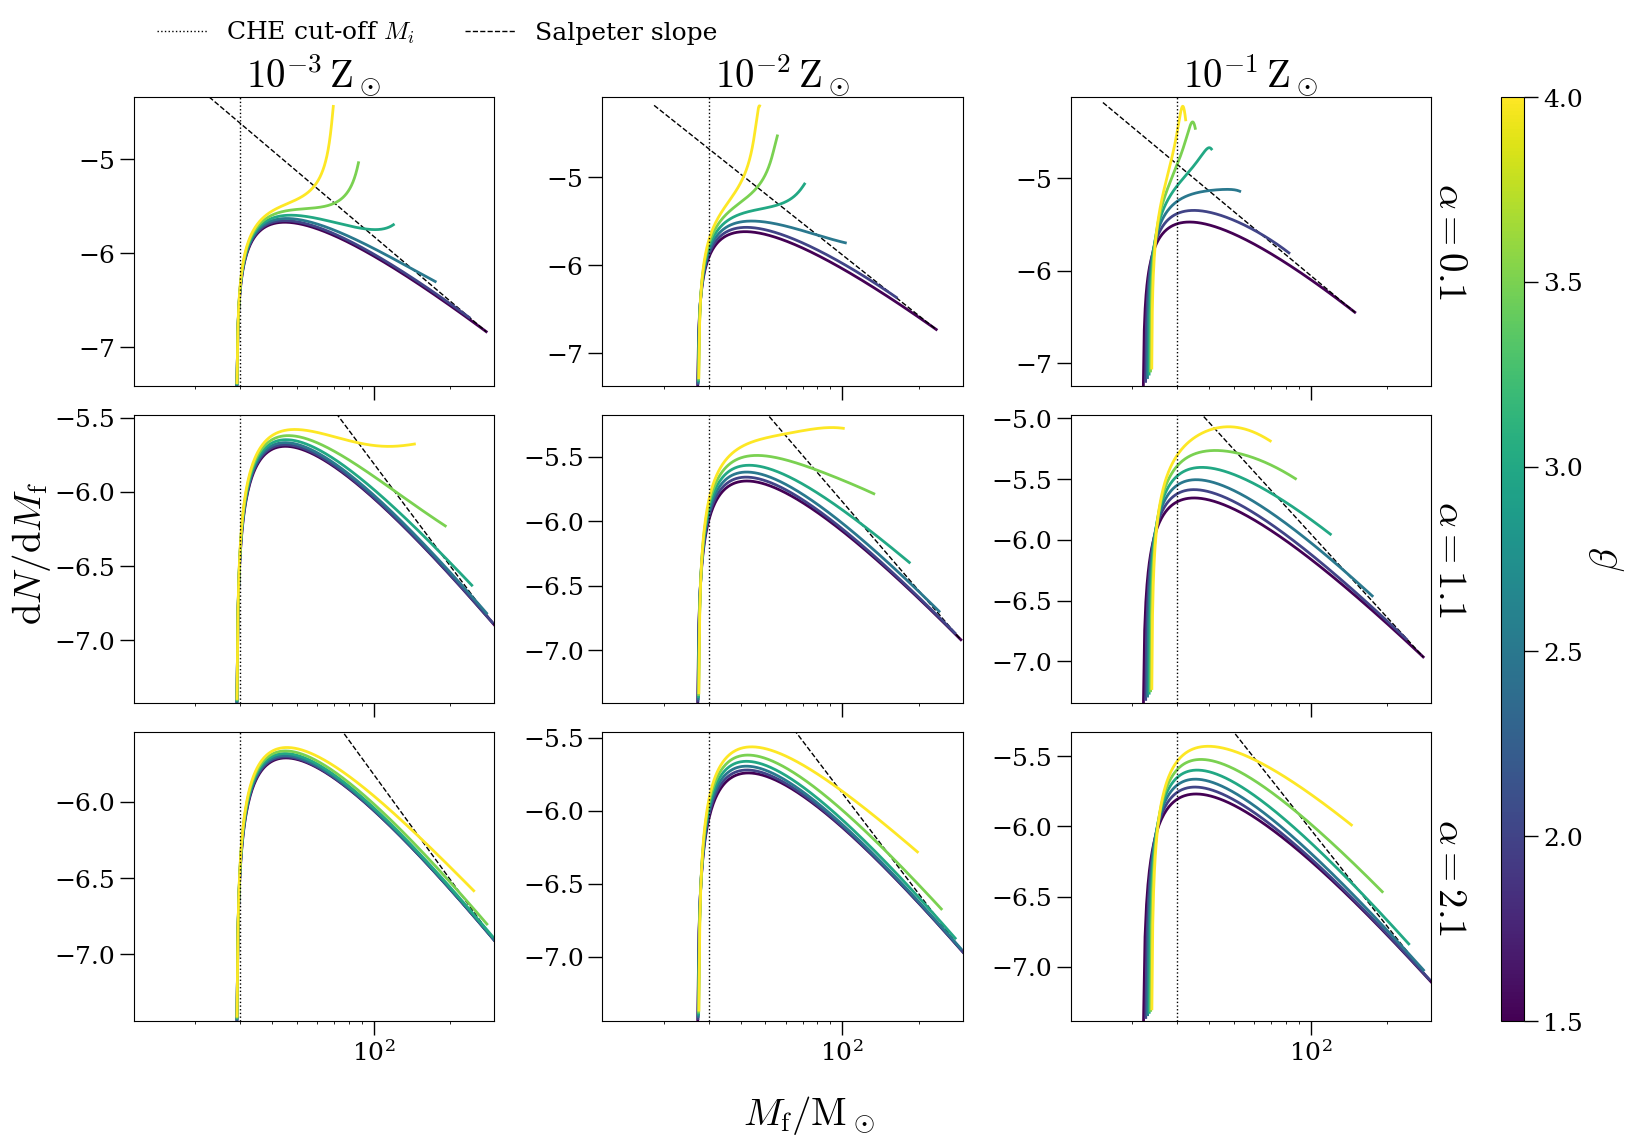

In [ ]:
m_i_arr = np.linspace(20, 300, 1000)
Z_arr = Z_SUN * 10.**np.arange(-3, 0, 1)
beta_arr = np.arange(1.5, 4.5, 0.5)
alpha_arr = np.arange(0.1, 3, 1)
gamma = 0.5
M_r = 30
tau_r = 1e6
Mdot_r = 1e-5
che_lower_slope = 0.002
che_upper_slope = 0.01
che_p_min = 0.4
che_m_min = 30
cmap = cm.viridis

fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
fig.subplots_adjust(wspace=0.3, hspace=0.1)

for i, alpha in enumerate(alpha_arr):
    for j, Z in enumerate(Z_arr):
        ax = axes[i, j]
        
        y_min = np.inf
        y_max = -np.inf
        x_min = np.inf
        x_max = -np.inf
        for k, beta in enumerate(beta_arr):
            c = cmap((beta-beta_arr.min()) / (beta_arr.max() - beta_arr.min()))
            x_arr = mf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)
            
            y_arr = safe_log10(
                dmi_dmf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r) 
                * dn_dmi(m_i_arr)
                * dnche_dn(m_i_arr, che_m_min, che_p_min, che_lower_slope, che_upper_slope)
            )
            ax.plot(x_arr, y_arr, label=f'β={beta:.1f}', c=c)
            
            y_min = np.nanmin((y_min, np.nanmin(y_arr)))
            y_max = np.nanmax((y_max, np.nanmax(y_arr)))
            x_min = np.nanmin((x_min, np.nanmin(x_arr)))
            x_max = np.nanmax((x_max, np.nanmax(x_arr)))
            
            if k == 0:
                ref_i = -1
                mpeak = x_arr[ref_i]
                y_arr = np.log10(x_arr**-2.3 / mpeak**-2.3 * 10.**y_arr[ref_i])
                ax.plot(x_arr, y_arr, 'k--', lw=1)

        if i == 0:
            ax.set_title(f'$10^{{{np.log10(Z/Z_SUN):.0f}}}\\,\\mathrm{{Z}}_\\odot$')
        
        if j == len(Z_arr)-1:
            ax.text(1, 0.5, f'$\\alpha={alpha:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
            
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max+0.1)
        ax.vlines(che_m_min, y_min, y_max+0.1, ls=':', color='k', lw=1)

for ax in axes.ravel():
    ax.set_xscale('log')

fig.text(0.08, 0.5, '$\mathrm{d}N/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)
fig.text(0.5, 0.05, '$M_\\mathrm{f}/\\mathrm{M}_\\odot$', rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=beta_arr.min(), vmax=beta_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('$\\beta$')

    
# LEGEND
handles = [
    ax.plot([], [], 'k:', label='CHE cut-off $M_i$', lw=1)[0],
    ax.plot([], [], 'k--', label='Salpeter slope', lw=1)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

We can now identify multiple competing trends

* $\alpha/\beta$ the more $\beta>\alpha$, the more do high $M_i$ stars create a $M_f$ pile-up. In many cases, however, a significant contribution from the lower edge of the CHE window, favored by the IMF, is seen. The presence of this "IMF pile-up" is determined chiefly by
* $\dot{M}_r\times\gamma$ the wind and IMF pile-ups only "merge" if the baseline mass-loss rate is high enough. That is a function of metallicity, and set by $\dot{M}_r\zeta^\gamma$. However, the presence of a wind pile-up that can even merge with the IMF pile-up still depends on $\alpha/\beta$. If $\beta\sim\alpha$, there is no wind pile-up, and the distribution is always dominated by the IMF pile-up. The position of the IMF pile-up, however can still be significantly downshifted for high $\dot{M}_r\zeta^\gamma$  This also incurs a flattening and a high mass cut-off.

For *fixed metallicity*. For the evolution over metallicity, $\gamma$ and $\dot{M}_r$ should matter independently. Accounting for that, we can identify four different final mass regimes for CHE stars.

In [220]:
def dnche_dmi(M_i, m_min, p_min, lower_slope, upper_slope):
    return (dnche_dn(M_i, m_min, p_min, lower_slope, upper_slope)
            * dn_dmi(M_i))

def dnche_dmf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r, che_m_min, che_p_min, che_lower_slope, che_upper_slope):
    return (dmi_dmf(m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r) 
            * dn_dmi(m_i_arr)
            * dnche_dn(m_i_arr, che_m_min, che_p_min, che_lower_slope, che_upper_slope))

In [195]:
from matplotlib.ticker import LogFormatter, LogLocator

def set_log_x_with_minor_format(ax):
    ax.set_xscale('log')
    ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax.xaxis.set_minor_formatter(LogFormatter(labelOnlyBase=False))


Text(0.9, 1, '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\\odot)^\\gamma(M_r/M_r)^\\beta$\n$M_r=30\\,\\mathrm{M}_\\odot$, $\\tau_r=10^{6.0}\\,\\mathrm{yr}$, $\\dot{M}_r=10^{-5.0}\\,\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$, $\\alpha=0.2$')

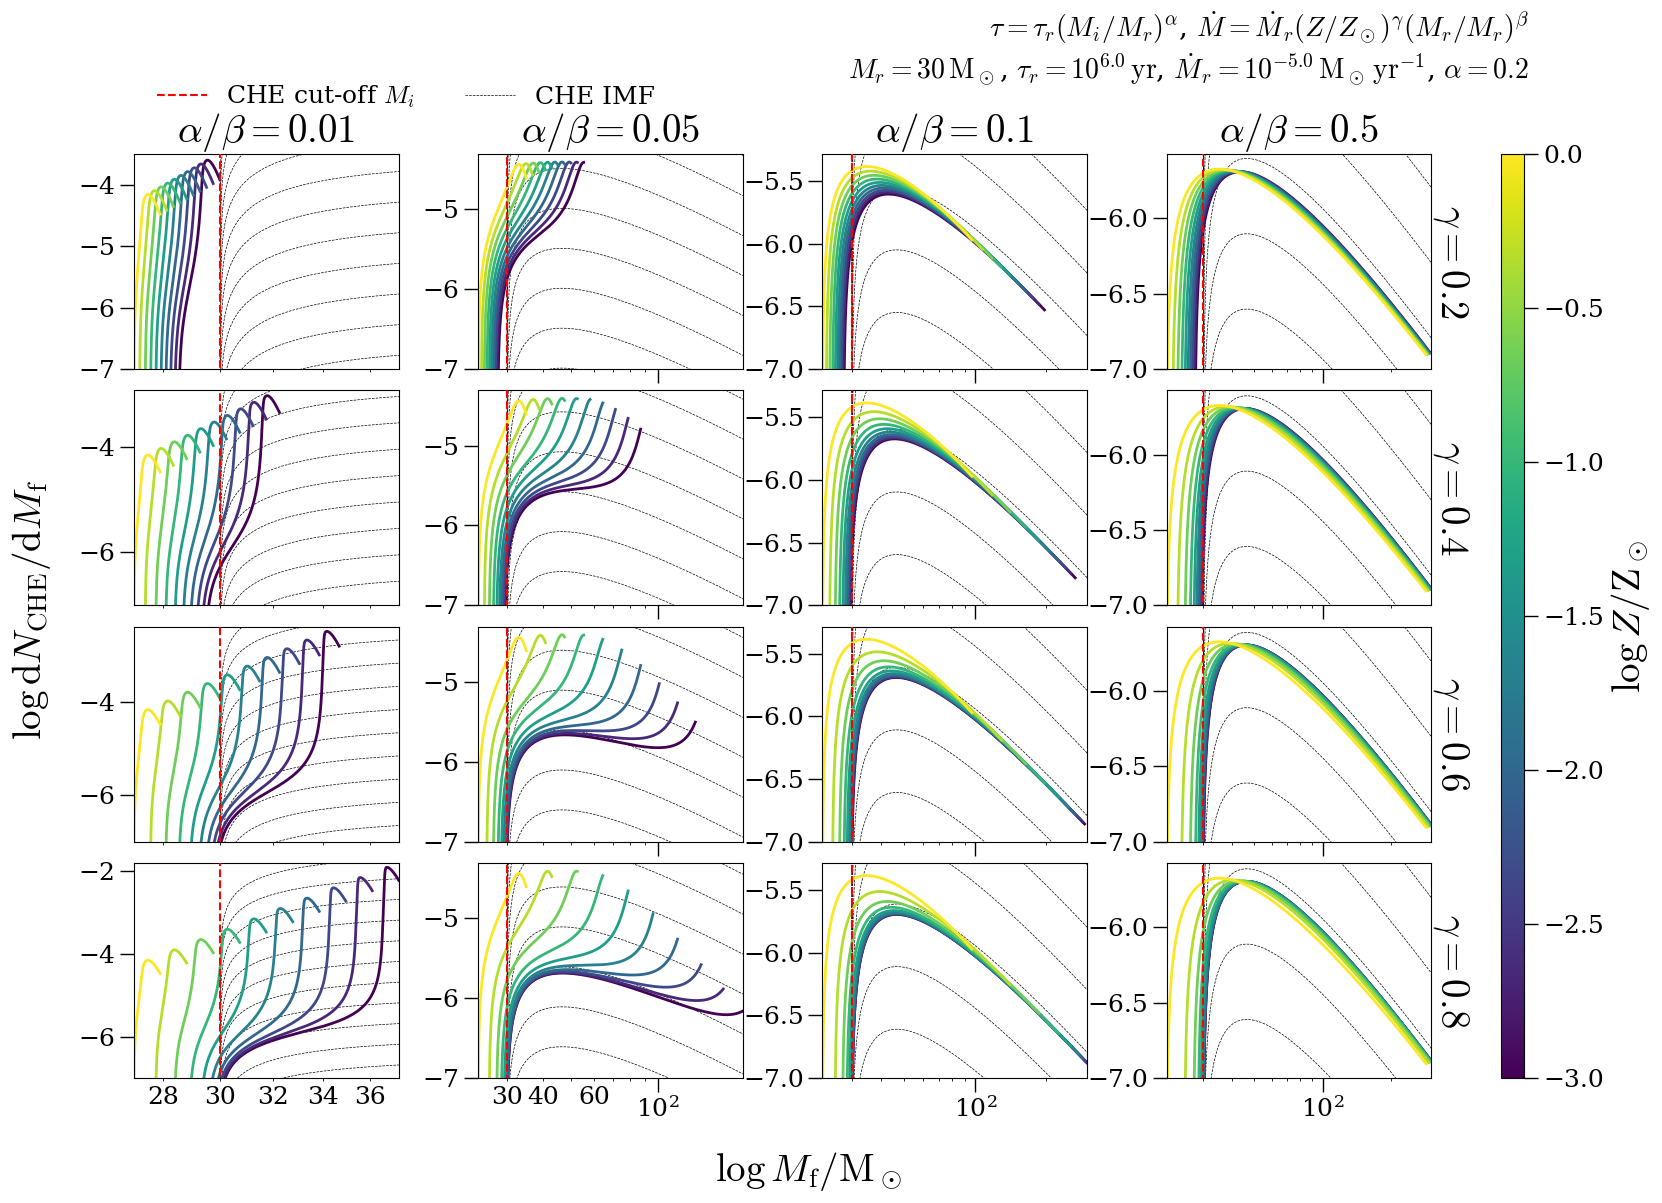

In [232]:
# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.01, 0.05, 0.1, 0.5]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 10) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)

## Plot settings
figsize = (18, 12)
cmap = cm.viridis
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.1 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -7
abs_max_y = -1.5
x_log_scale = True

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for k, logz in enumerate(log_z_arr):
            c = cmap((logz - log_z_arr.min()) / (log_z_arr.max() - log_z_arr.min()))
            Z = Z_arr[k]
            beta = alpha/alpha_div_beta
            args = (m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)

            m_f_arr = mf(*args)
            dnche_dmf_arr = dnche_dmf(*args, *che_args)

            # There are some high gamma, ~solar metallicity configurations
            # for which the masses fall steeply, well below the usual 
            # and break the plot, so we simply remove them for now
            x_arr = m_f_arr[m_f_arr > 1]
            y_arr = safe_log10(dnche_dmf_arr)[m_f_arr > 1]
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 6, 0.5):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=log_z_arr.min(), vmax=log_z_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

Say $M_\mathrm{pile}$ is the pile-up mass set by winds. Then our four cases are

* **Strong winds ($\dot{M}_r\zeta^\gamma\gtrsim M_r/\tau_r$) with strong scaling ($\alpha/\beta<1-B$)**: $M_\mathrm{pile}<M_\mathrm{min}^\mathrm{CHE}$, and massive stars lose much more mass. Both the wind peak and the CHE IMF peak are shifted to the same lower mass, and merge into a single, very prominent peak.
* **Weak winds ($\dot{M}_r\zeta^\gamma\lesssim M_r/\tau_r$) with strong scaling ($\alpha/\beta<1-B$)**: $M_\mathrm{pile}>M_\mathrm{min}^\mathrm{CHE}$, and massive stars lose much more mass. The CHE IMF peak remains in the same place, while a wind peak is produced somewhere above. The result is a douple-peaked distribution, or a sharp high-mass peak with a low-mass plateau.
* **Strong winds ($\dot{M}_r\zeta^\gamma\gtrsim M_r/\tau_r$) with weak scaling ($\alpha/\beta>1-B$)**: $M_\mathrm{pile}<M_\mathrm{min}^\mathrm{CHE}$, and all stars lose comparable mass. The whole distribution is shifted down and only somewhat flattened, with a high-mass cut-off.
* **Weak winds ($\dot{M}_r\zeta^\gamma\lesssim M_r/\tau_r$) with weak scaling ($\alpha/\beta>1-B$)**: $M_\mathrm{pile}>M_\mathrm{min}^\mathrm{CHE}$, and all stars lose comparable mass. The distribution remains very close to the original CHE IMF, with only slight downshift and high-mass cutoff.

Crucially, this means that $M_\mathrm{min}^\mathrm{CHE}$ is another important parameter. It sets the position of the CHE IMF peak, which affects whether the wind pile-up will dominate the final mass distribution or not. For example, because the IMF favors lower masses, shifting $M_\mathrm{min}^\mathrm{CHE}$ down will make it harder to for the wind pile-up to dominate the distribution, and vice-versa.

Text(0.9, 1, '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\\odot)^\\gamma(M_r/M_r)^\\beta$\n$M_r=30\\,\\mathrm{M}_\\odot$, $\\tau_r=10^{6.0}\\,\\mathrm{yr}$, $\\dot{M}_r=10^{-5.0}\\,\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$, $\\alpha=0.2$')

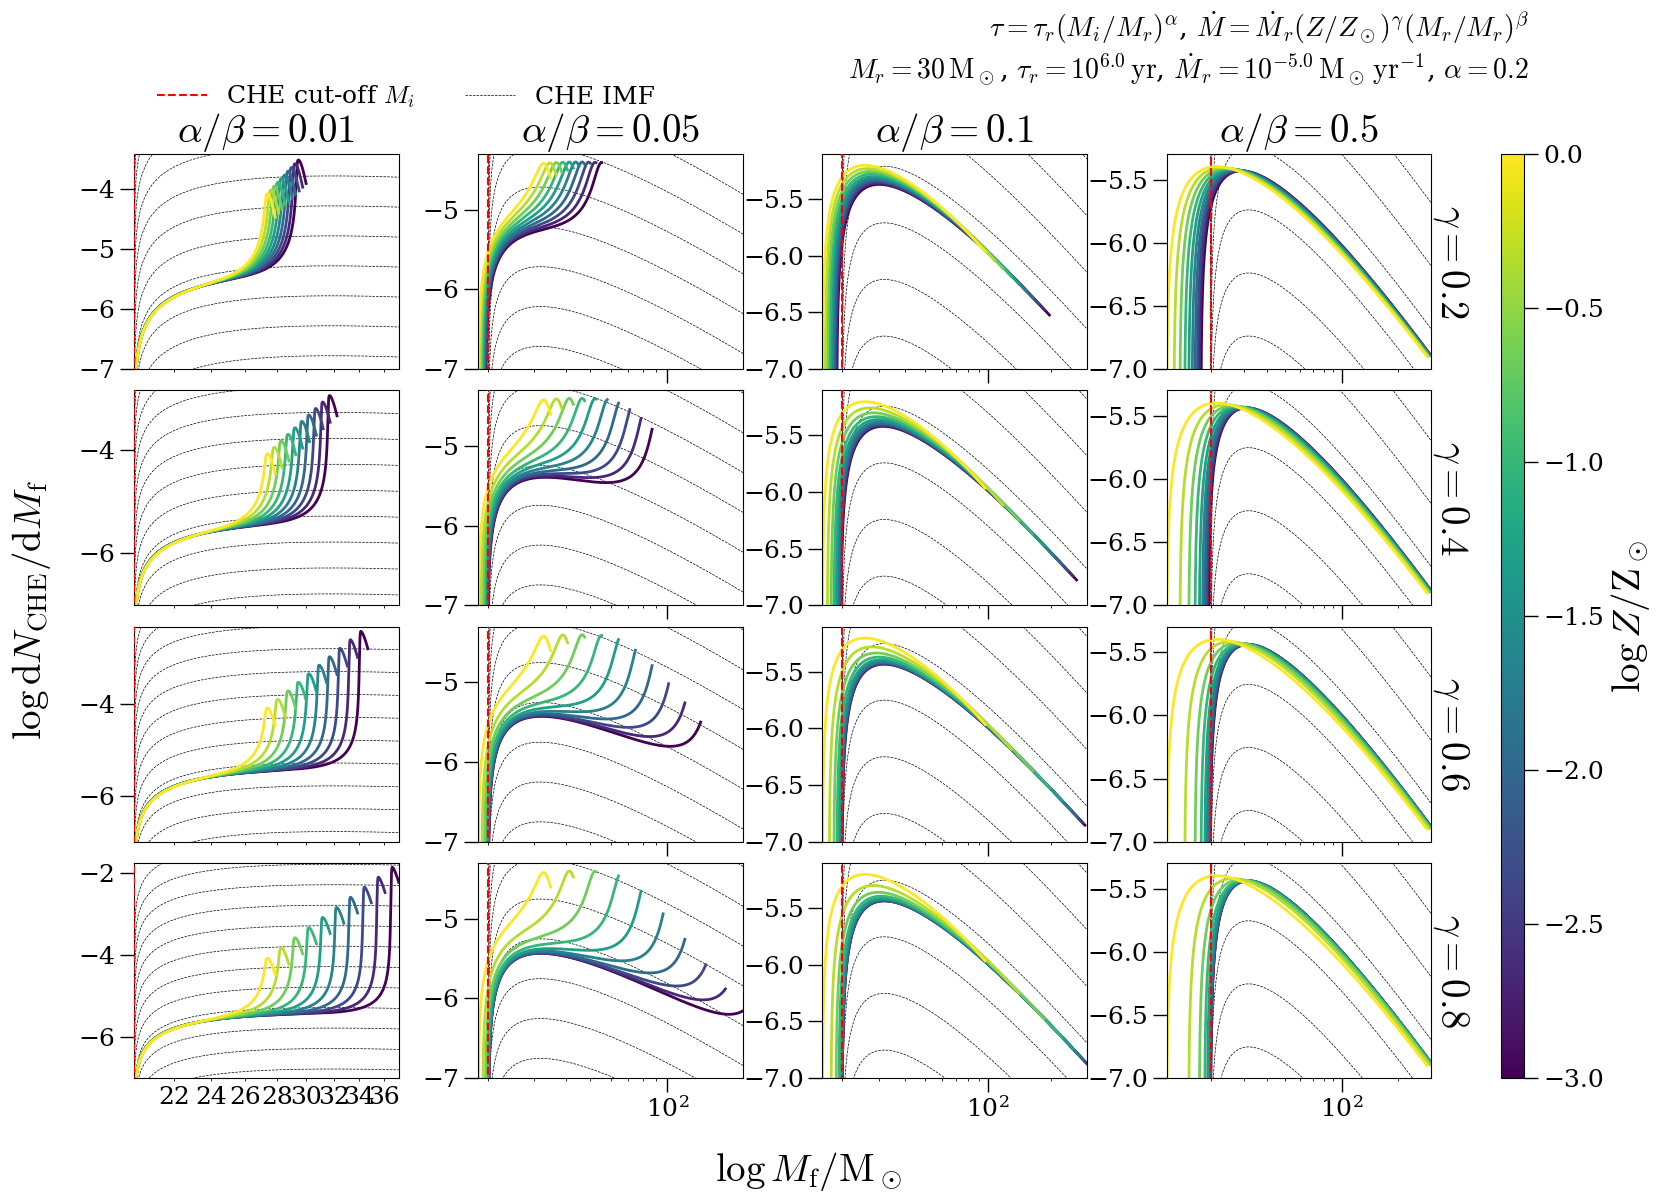

In [234]:
# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.01, 0.05, 0.1, 0.5]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 10) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 20 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)

## Plot settings
figsize = (18, 12)
cmap = cm.viridis
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.1 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -7
abs_max_y = -1.5
x_log_scale = True

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for k, logz in enumerate(log_z_arr):
            c = cmap((logz - log_z_arr.min()) / (log_z_arr.max() - log_z_arr.min()))
            Z = Z_arr[k]
            beta = alpha/alpha_div_beta
            args = (m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)

            m_f_arr = mf(*args)
            dnche_dmf_arr = dnche_dmf(*args, *che_args)

            # There are some high gamma, ~solar metallicity configurations
            # for which the masses fall steeply, well below the usual 
            # and break the plot, so we simply remove them for now
            x_arr = m_f_arr[m_f_arr > 1]
            y_arr = safe_log10(dnche_dmf_arr)[m_f_arr > 1]
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 6, 0.5):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=log_z_arr.min(), vmax=log_z_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

Text(0.9, 1, '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\\odot)^\\gamma(M_r/M_r)^\\beta$\n$M_r=30\\,\\mathrm{M}_\\odot$, $\\tau_r=10^{6.0}\\,\\mathrm{yr}$, $\\dot{M}_r=10^{-5.0}\\,\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$, $\\alpha=0.2$')

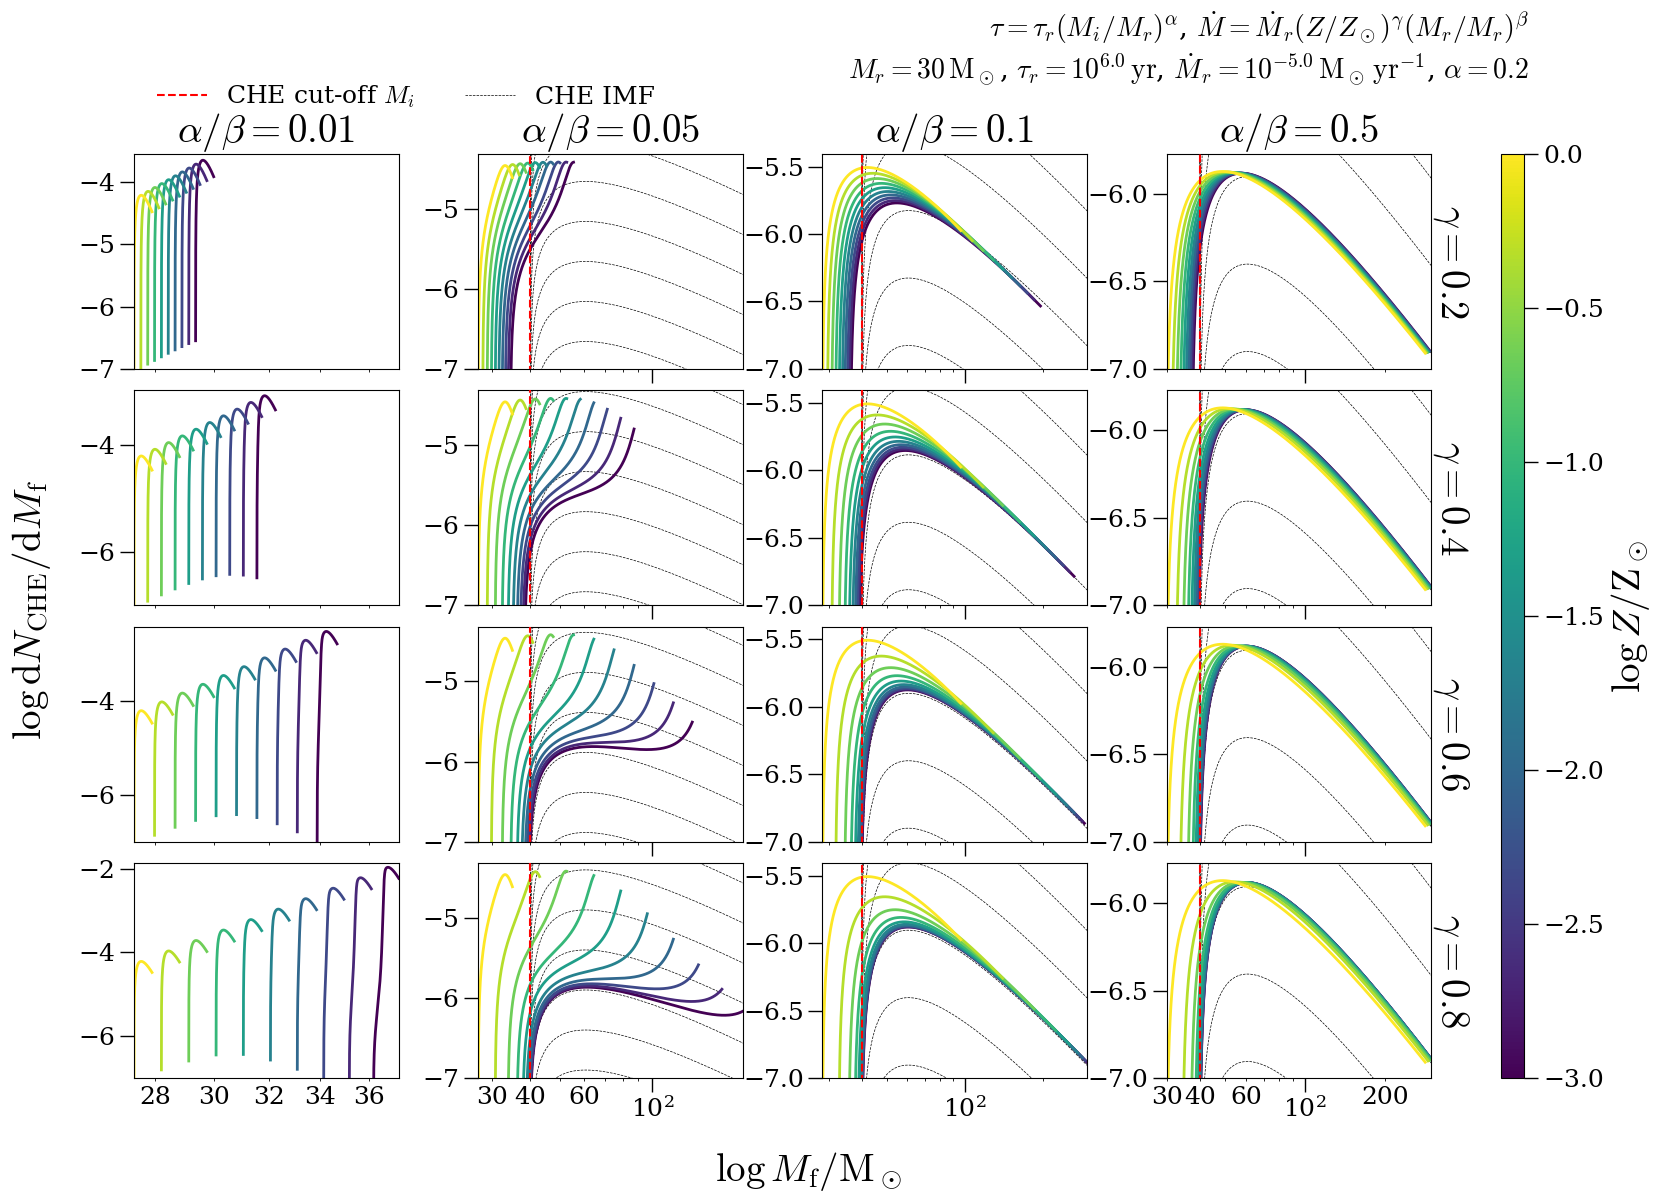

In [235]:
# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.01, 0.05, 0.1, 0.5]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 10) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 40 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)

## Plot settings
figsize = (18, 12)
cmap = cm.viridis
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.1 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -7
abs_max_y = -1.5
x_log_scale = True

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for k, logz in enumerate(log_z_arr):
            c = cmap((logz - log_z_arr.min()) / (log_z_arr.max() - log_z_arr.min()))
            Z = Z_arr[k]
            beta = alpha/alpha_div_beta
            args = (m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)

            m_f_arr = mf(*args)
            dnche_dmf_arr = dnche_dmf(*args, *che_args)

            # There are some high gamma, ~solar metallicity configurations
            # for which the masses fall steeply, well below the usual 
            # and break the plot, so we simply remove them for now
            x_arr = m_f_arr[m_f_arr > 1]
            y_arr = safe_log10(dnche_dmf_arr)[m_f_arr > 1]
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 6, 0.5):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=log_z_arr.min(), vmax=log_z_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('$\\log Z/\\mathrm{Z}_\\odot$')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

In practice, a similar effect will be associated to $P_\mathrm{min}^\mathrm{CHE}$, and the slopes of the upper and lower edges of the CHE window. Those parameters are all fundamentally linked to the efficiency of rotation mixing, which within MESA is controlled by $f_\mathrm{ES}$, a multiplicative factor to the rotational mixing diffusion coefficient $D_\mathrm{CHE}$. We thus add $f_\mathrm{ES}$ to our list of "controls" for the CHE final mass distribution.

That the aspect of the distribution can vary strongly with metallicity means that the aspect of the cosmological population will depend also on the metallicity distribution $\mathrm{d}P/\mathrm{d}\log Z$. For this we assume the skewed log-normal distribution from van Son et al. (2022).

In [ ]:
from scipy.stats import norm as NormDist

def find_metallicity_distribution(redshifts, min_logZ_COMPAS, max_logZ_COMPAS,
                                  mu0=0.035, muz=-0.23, sigma_0=0.39, 
                                  sigma_z=0.0, alpha=0.0, min_logZ=-12.0, 
                                  max_logZ=0.0, step_logZ=0.01):
    """
    Calculate the distribution of metallicities at different redshifts 
    using a log skew normal distribution. The log-normal distribution 
    is a special case of this log skew normal distribution and is 
    retrieved by setting the skewness to zero (alpha=0). Based on the 
    method in Neijssel+19. Default values retrieve the dP/dZ 
    distribution used in Neijssel+19. See van Son+2022 for skewed 
    log-normal distribution.

    NOTE: This assumes that metallicities in COMPAS are drawn from a 
    flat-in-log distribution!

    Args:
        max_redshift       --> [float] Max redshift for calculation
        redshift_step      --> [float] Step used in redshift calculation
        min_logZ_COMPAS    --> [float] Min logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float] Max logZ value that COMPAS samples
        mu0                --> [float] Location (mean in normal) at z=0
        muz                --> [float] Redshift scaling of location
        sigma_0            --> [float] Scale (variance in normal) at z=0
        sigma_z            --> [float] Redshift scaling of the scale
        alpha              --> [float] Shape (skewness, alpha=0 gives 
                                  normal dist as in Neijssel+19)
        min_logZ           --> [float] Min logZ for dPdlogZ calculation
        max_logZ           --> [float] Max logZ for dPdlogZ calculation
        step_logZ          --> [float] Step size for logZ range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a 
                                  particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which 
                                  dPdlogZ is evaluated
        p_draw_metallicity --> [float] Probability of drawing a certain 
                                  metallicity in COMPAS
    """
    # Log-linear redshift dependence of sigma
    sigma = sigma_0 * 10**(sigma_z * redshifts)

    # Mean metallicities evolve with redshift (Langer & Norman 2006)
    mean_metallicities = mu0 * 10**(muz * redshifts)

    # Rewrite expected value of log-skew-normal to retrieve mu
    beta = alpha / (np.sqrt(1 + alpha**2))
    PHI = NormDist.cdf(beta * sigma)
    mu_metallicities = np.log(mean_metallicities / 2. / 
                              (np.exp(0.5 * sigma**2) * PHI))

    # Create a range of metallicities (x-values or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)

    # Probabilities of log-skew-normal (without 1/Z factor)
    dPdlogZ = (2. / sigma[:, np.newaxis] * 
               NormDist.pdf((log_metallicities - mu_metallicities[:, np.newaxis]) / sigma[:, np.newaxis]) * 
               NormDist.cdf(alpha * (log_metallicities - mu_metallicities[:, np.newaxis]) / sigma[:, np.newaxis]))

    # Normalize distribution over all metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ / norm[:, np.newaxis]

    # Flat-in-log distribution for sampled metallicity in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)

    return dPdlogZ, metallicities, p_draw_metallicity


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [356]:
min_redshift = 0.
max_redshift = 10.
redshift_step = 1.
redshifts = np.arange(min_redshift, max_redshift + redshift_step, redshift_step)

# van Son et al. (2023) ApJ 948 105 Tab 1
mu0 = 0.025
muz = -0.049
sigma0 = 1.122
sigmaz = 0.049
alpha = -1.778
min_logZ = -12.0
max_logZ = np.log(0.1 * Z_SUN) 
step_logZ = 0.01

min_Z = 10.**Z_arr.min()
max_Z = 10.**Z_arr.max()

dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(
    redshifts=redshifts,
    min_logZ_COMPAS=np.log(min_Z),
    max_logZ_COMPAS=np.log(max_Z),
    mu0=mu0,
    muz=muz,
    sigma_0=sigma0,
    sigma_z=sigmaz,
    alpha=alpha,
    min_logZ=min_logZ,
    max_logZ=max_logZ,
    step_logZ=step_logZ
)

In [364]:
np.log(1)

0.0

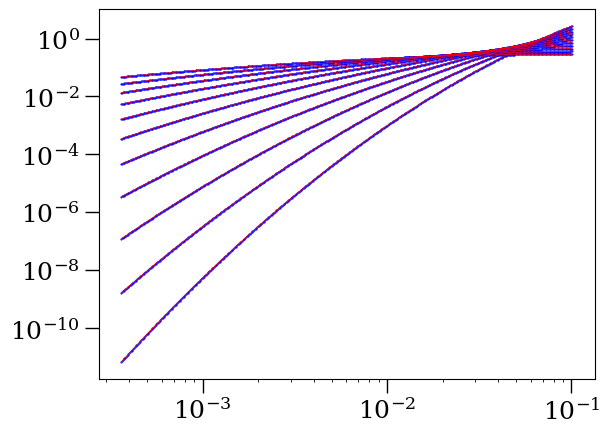

In [357]:
for arr in dPdlogZ:
    ip = CubicSpline(metallicities, arr)
    plt.scatter(metallicities/Z_SUN, arr, c='b', marker='.', s=1)
    plt.plot(metallicities/Z_SUN, ip(metallicities), c='r', lw=0.5)
plt.xscale('log')
plt.yscale('log')

In [358]:
def metallicity_convolve(
    redshift_arr,
    m_i_arr,
    Mdot_r,
    Z_arr,
    alpha,
    alpha_div_beta,
    gamma,
    M_r,
    tau_r,
    che_args,
    mu0=0.025,
    muz=-0.049,
    sigma0=1.122,
    sigmaz=0.049,
    alphaz=-1.778,
    min_logZ=-12.0,
    max_logZ=0.0,
    step_logZ=0.01
    ):
    
    min_Z = 10.**Z_arr.min() * Z_SUN
    max_Z = 10.**Z_arr.max() * Z_SUN
    
    dPdlogZ, metallicities, _ = find_metallicity_distribution(
                    redshifts=redshift_arr,
                    min_logZ_COMPAS=np.log(min_Z), # yes ln not log10
                    max_logZ_COMPAS=np.log(max_Z), # yes ln not log10
                    mu0=mu0,
                    muz=muz,
                    sigma_0=sigma0,
                    sigma_z=sigmaz,
                    alpha=alphaz,
                    min_logZ=min_logZ,
                    max_logZ=max_logZ,
                    step_logZ=step_logZ
            )
    dPdlogZ = dPdlogZ[0]
    spline = CubicSpline(np.log10(metallicities/Z_SUN), dPdlogZ)
    logZ_bin_centers = np.log10(Z_arr/Z_SUN)
    dlogZ = np.diff(logZ_bin_centers)[0]
    logZ_bin_edges = np.arange(logZ_bin_centers.min() - dlogZ/2, logZ_bin_centers.max() + dlogZ, dlogZ)
    logZ_bin_weights = np.array([
        spline.integrate(logZ_bin_edges[i], logZ_bin_edges[i+1]) for i in range(len(logZ_bin_edges)-1)
    ])
    
    mass_bin_edges = np.linspace(20, 300, 101)
    mass_bin_weights = np.zeros_like(mass_bin_edges[:-1])
    
    for k, Z in enumerate(Z_arr):
        Z = Z_arr[k]
        beta = alpha/alpha_div_beta
        args = (m_i_arr, Mdot_r, Z, alpha, beta, gamma, M_r, tau_r)

        m_f_arr = mf(*args)
        dnche_dmf_arr = dnche_dmf(*args, *che_args)

        for i, m_f in enumerate(m_f_arr):
            # Calculate the probability of drawing a metallicity
            # for each mass bin
            if m_f < mass_bin_edges[0] or m_f > mass_bin_edges[-1]:
                continue
            # Find the bin index for the mass
            bin_index = np.digitize(m_f, mass_bin_edges) - 1
            mass_bin_weights[bin_index] += dnche_dmf_arr[i] * logZ_bin_weights[k]

    x_arr = mass_bin_edges[:-1] + np.diff(mass_bin_edges) / 2
    y_arr = safe_log10(mass_bin_weights)
    
    return x_arr, y_arr

[-4.78470259 -4.75439956 -4.72409653 -4.6937935  -4.66349047 -4.63318744
 -4.60288441 -4.57258138 -4.54227835 -4.51197532 -4.48167229 -4.45136926
 -4.42106623 -4.3907632  -4.36046017 -4.33015714 -4.29985411 -4.26955108
 -4.23924805 -4.20894502 -4.17864199 -4.14833896 -4.11803593 -4.0877329
 -4.05742987 -4.02712684 -3.99682381 -3.96652078 -3.93621775 -3.90591471
 -3.87561168 -3.84530865 -3.81500562 -3.78470259 -3.75439956 -3.72409653
 -3.6937935  -3.66349047 -3.63318744 -3.60288441 -3.57258138 -3.54227835
 -3.51197532 -3.48167229 -3.45136926 -3.42106623 -3.3907632  -3.36046017
 -3.33015714 -3.29985411 -3.26955108 -3.23924805 -3.20894502 -3.17864199
 -3.14833896 -3.11803593 -3.0877329  -3.05742987 -3.02712684 -2.99682381
 -2.96652078 -2.93621775 -2.90591471 -2.87561168 -2.84530865 -2.81500562
 -2.78470259 -2.75439956 -2.72409653 -2.6937935  -2.66349047 -2.63318744
 -2.60288441 -2.57258138 -2.54227835 -2.51197532 -2.48167229 -2.45136926
 -2.42106623 -2.3907632  -2.36046017 -2.33015714 -2.

Text(0.9, 1, '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\\odot)^\\gamma(M_r/M_r)^\\beta$\n$M_r=30\\,\\mathrm{M}_\\odot$, $\\tau_r=10^{6.0}\\,\\mathrm{yr}$, $\\dot{M}_r=10^{-5.0}\\,\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$, $\\alpha=0.2$')

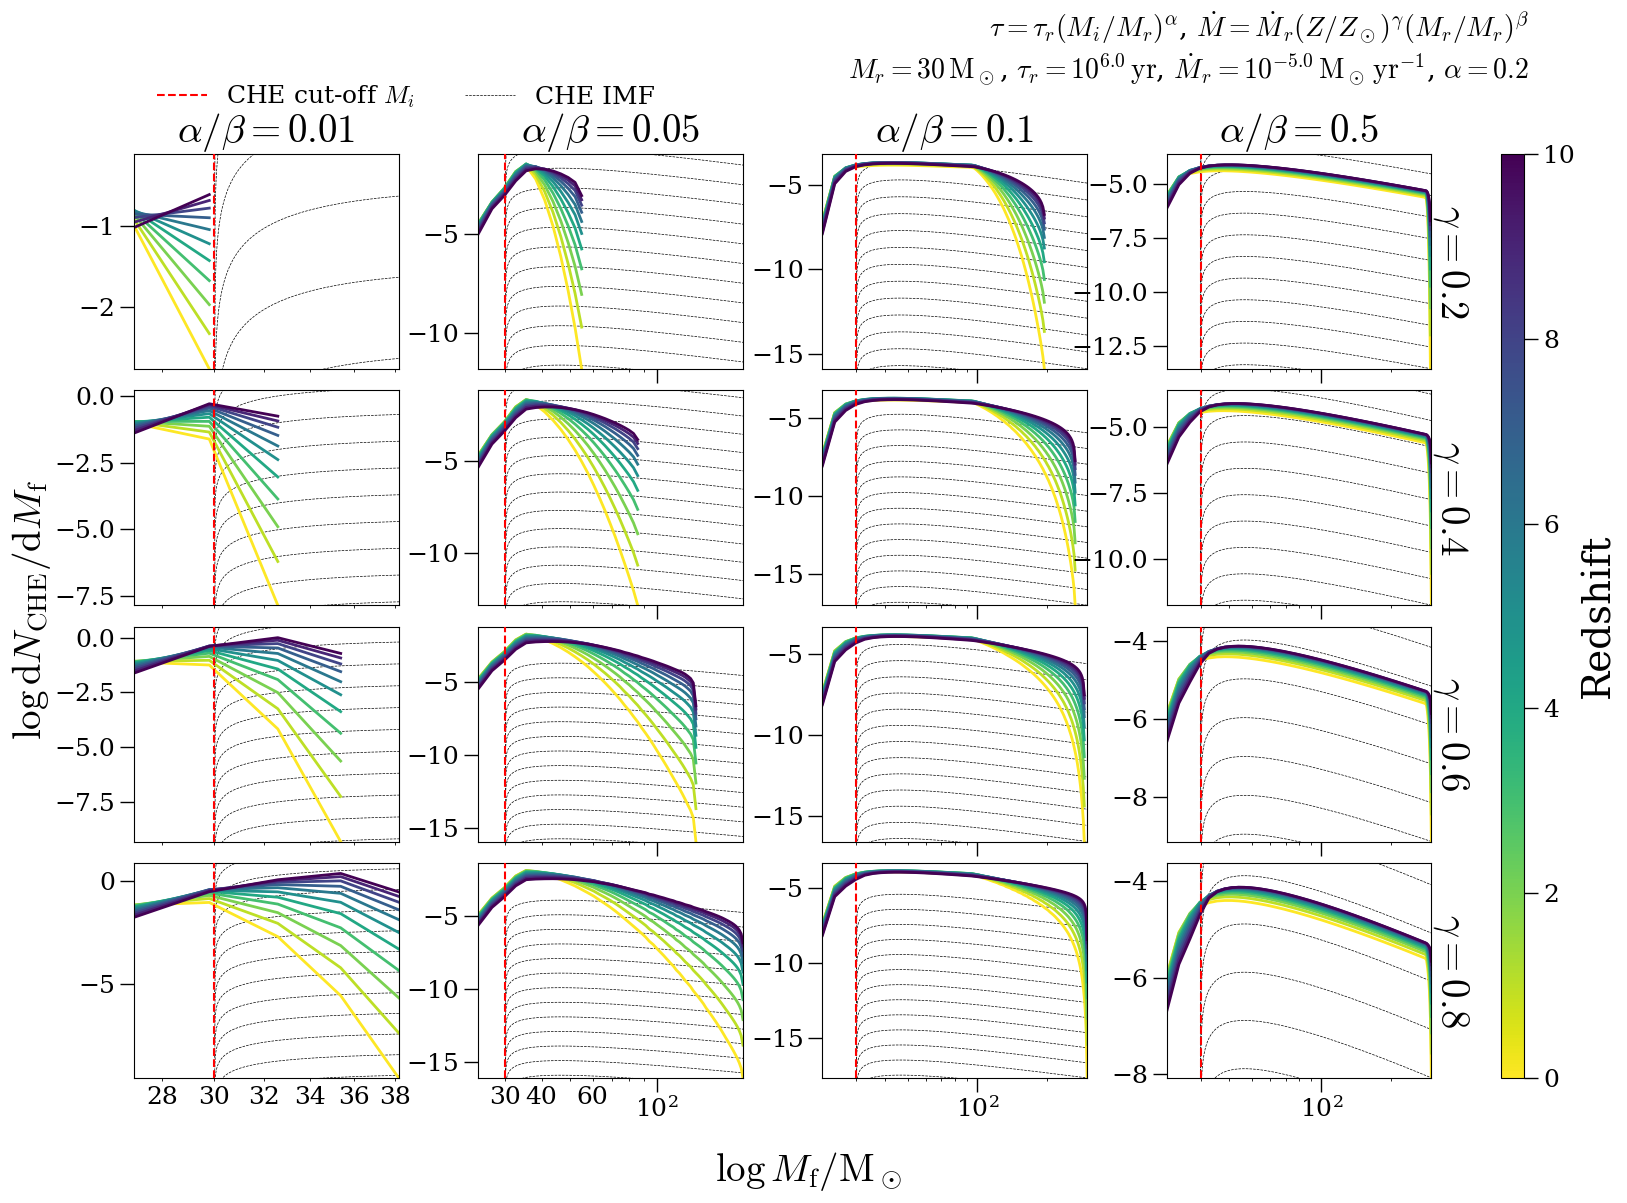

In [302]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.01, 0.05, 0.1, 0.5]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 100) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 1.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -np.inf
abs_max_y = np.inf
x_log_scale = True

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 12, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

In [306]:
0.2/1

0.2

KeyboardInterrupt: 

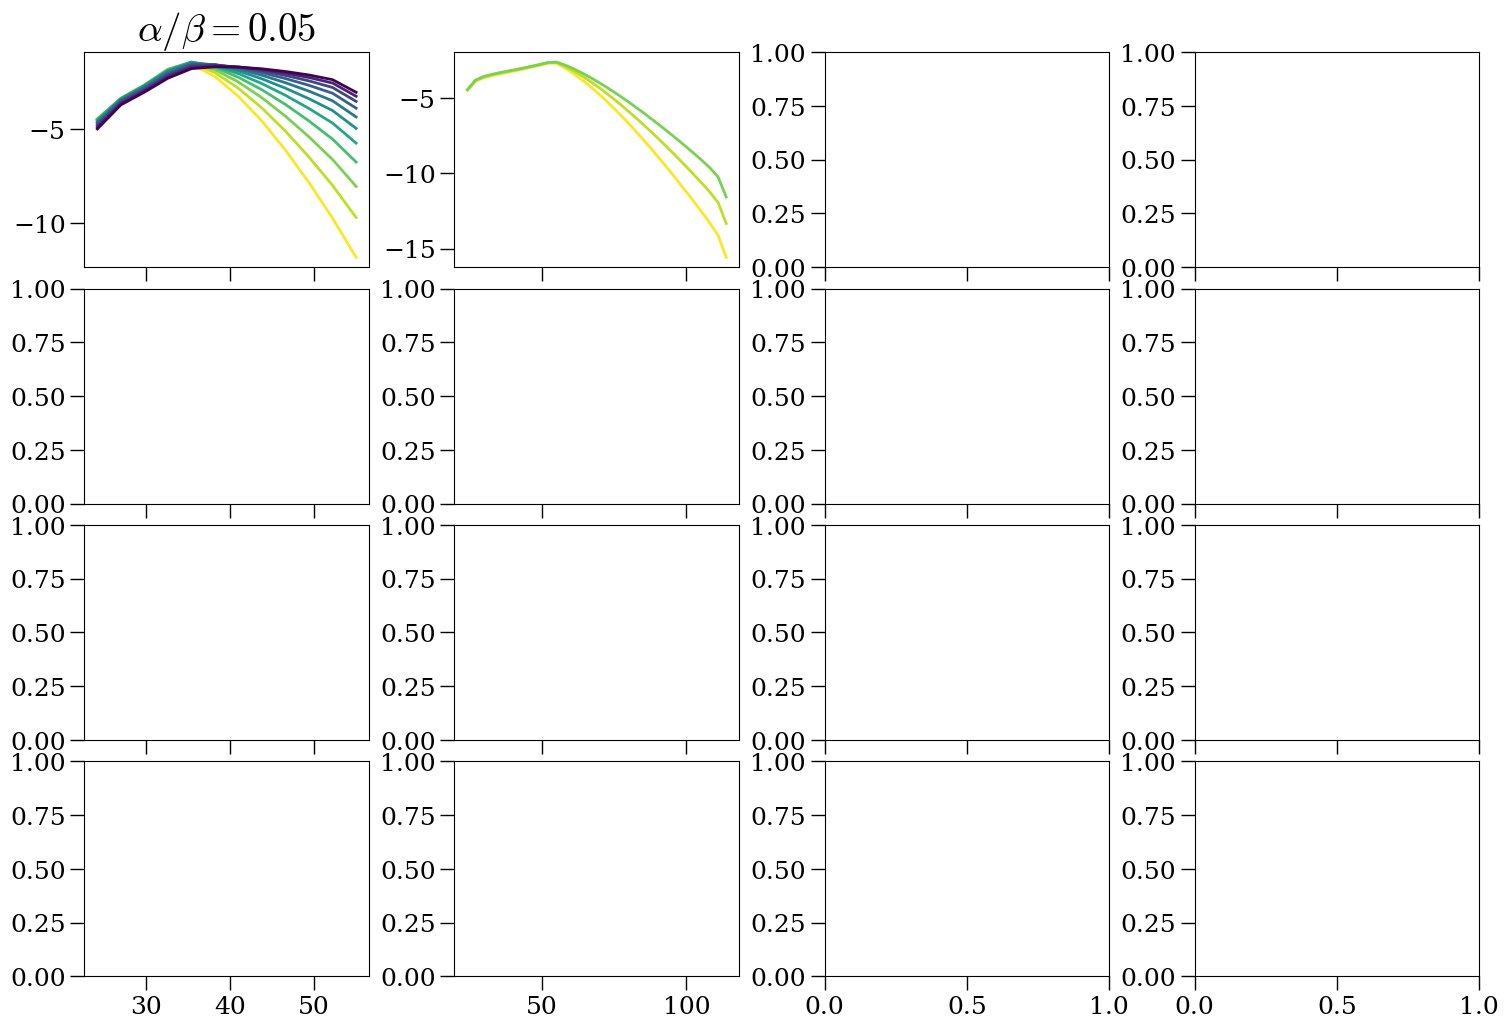

In [312]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.05, 0.075, 0.1, 0.19]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 100) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 1.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -np.inf
abs_max_y = np.inf
x_log_scale = True

save = True
fname = 'sv20winds_dnche_dmf_prediction'

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 12, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

if save:
    savefig(fig, fname)

CPU times: user 20min 37s, sys: 633 ms, total: 20min 37s
Wall time: 20min 37s


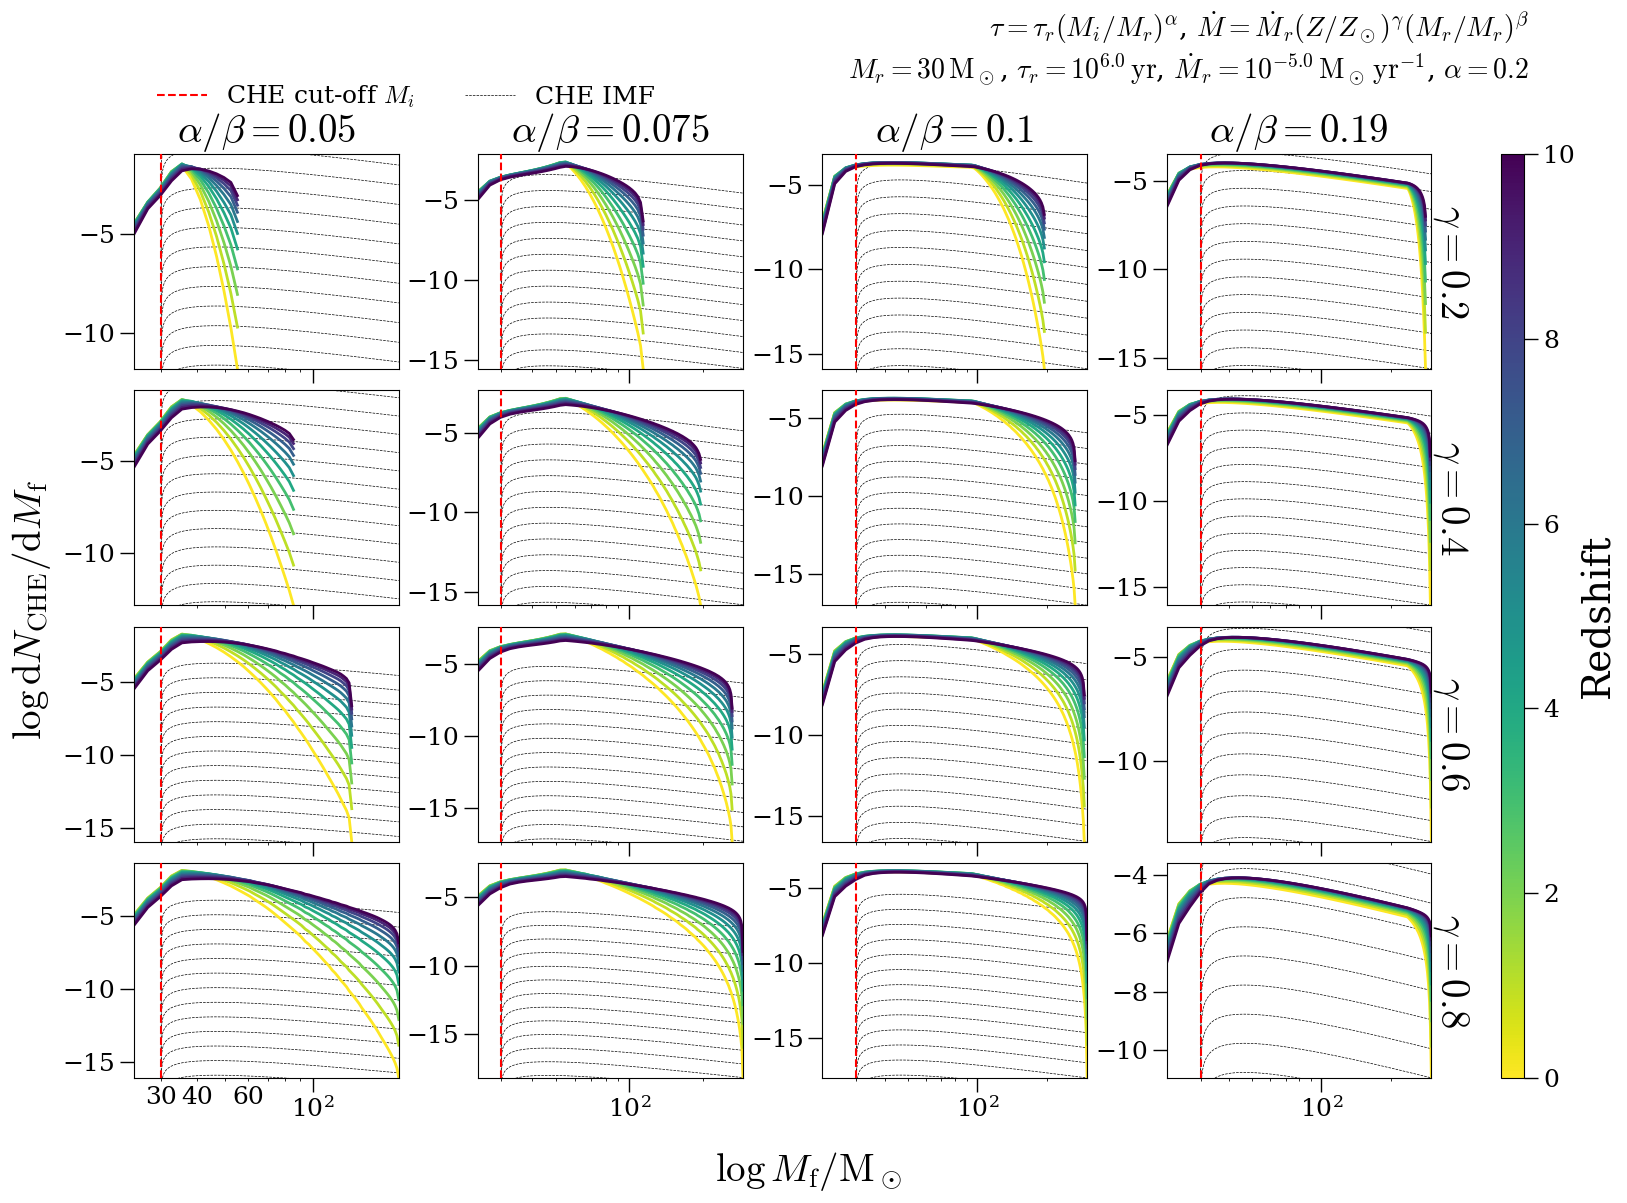

In [366]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.05, 0.075, 0.1, 0.19]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 100) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 1.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)
che_max_Z = 1 # assumed maximum metallciity for CHE

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -np.inf
abs_max_y = np.inf
x_log_scale = True

save = True
fname = 'sv20winds_dnche_dmf_prediction'

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args,
                max_logZ=np.log(che_max_Z)
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 12, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

if save:
    savefig(fig, fname)

CPU times: user 20min 38s, sys: 446 ms, total: 20min 39s
Wall time: 20min 39s


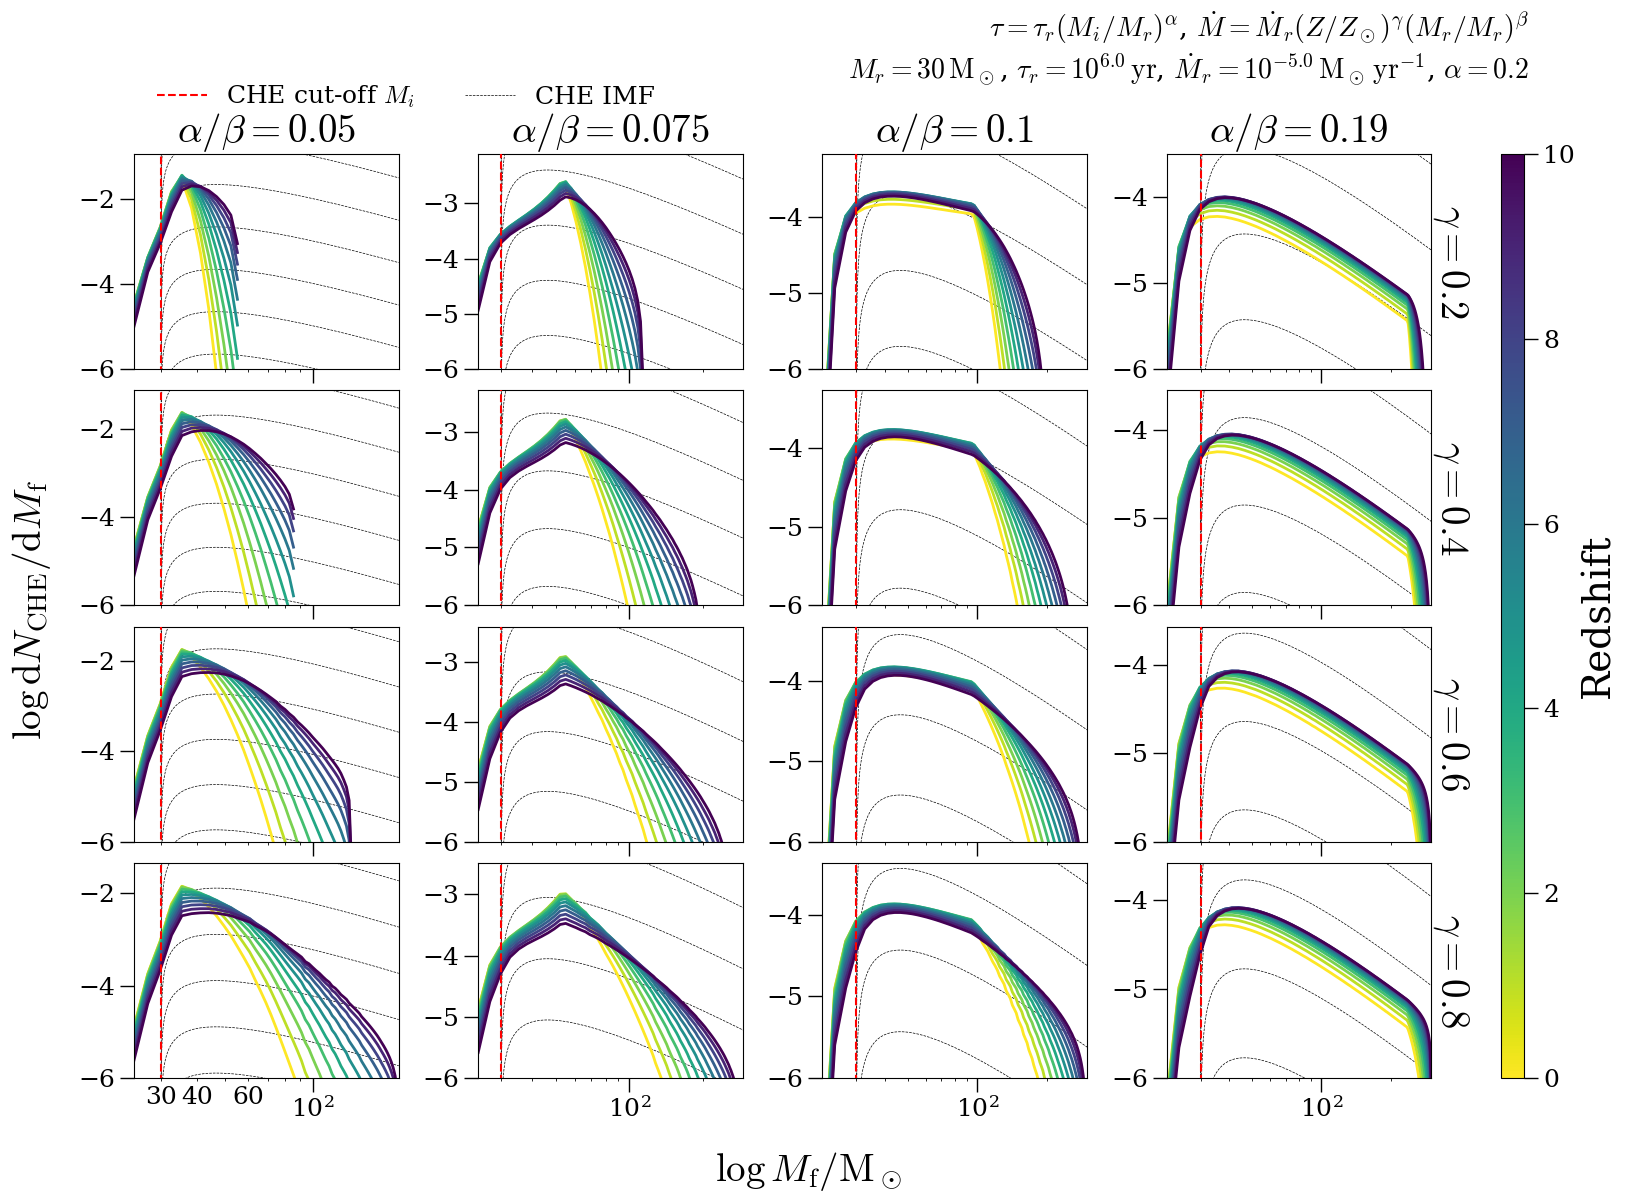

In [376]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.05, 0.075, 0.1, 0.19]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 100) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 1.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)
che_max_Z = 1 # assumed maximum metallciity for CHE

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -6
abs_max_y = np.inf
x_log_scale = True

save = True
fname = 'sv20winds_dnche_dmf_prediction'

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args,
                max_logZ=np.log(che_max_Z)
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-30, 30, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

if save:
    savefig(fig, fname)

While we do not model orbital widening, when thinking about mergers this introduces a strong cut on high-metallicities, as they will drive the orbits to delay times in excess of a Hubble time. MESA models can produce mergers from CHE up to $0.2\mathrm{Z}_\odot$, or even $0.4\,\mathrm{Z}_\odot$ in very finely tuned cases. At those metallicities, much of the surface He enrichment that allows the stars to avoid RLOF and keeps their masses wind-dominated is due to wind-stripping, and not mixing. Indeed, the lack of evidence for rotational mixing in contact binaries in the Magellanic Clouds suggests an upper limit of $0.1\,\mathrm{Z}_\odot$ for rotational mixing. We can have an idea of how strongly metallicity cuts affect the merger mass distribution by cutting the metallicities in our models manually.

CPU times: user 23.2 s, sys: 108 ms, total: 23.3 s
Wall time: 23.3 s


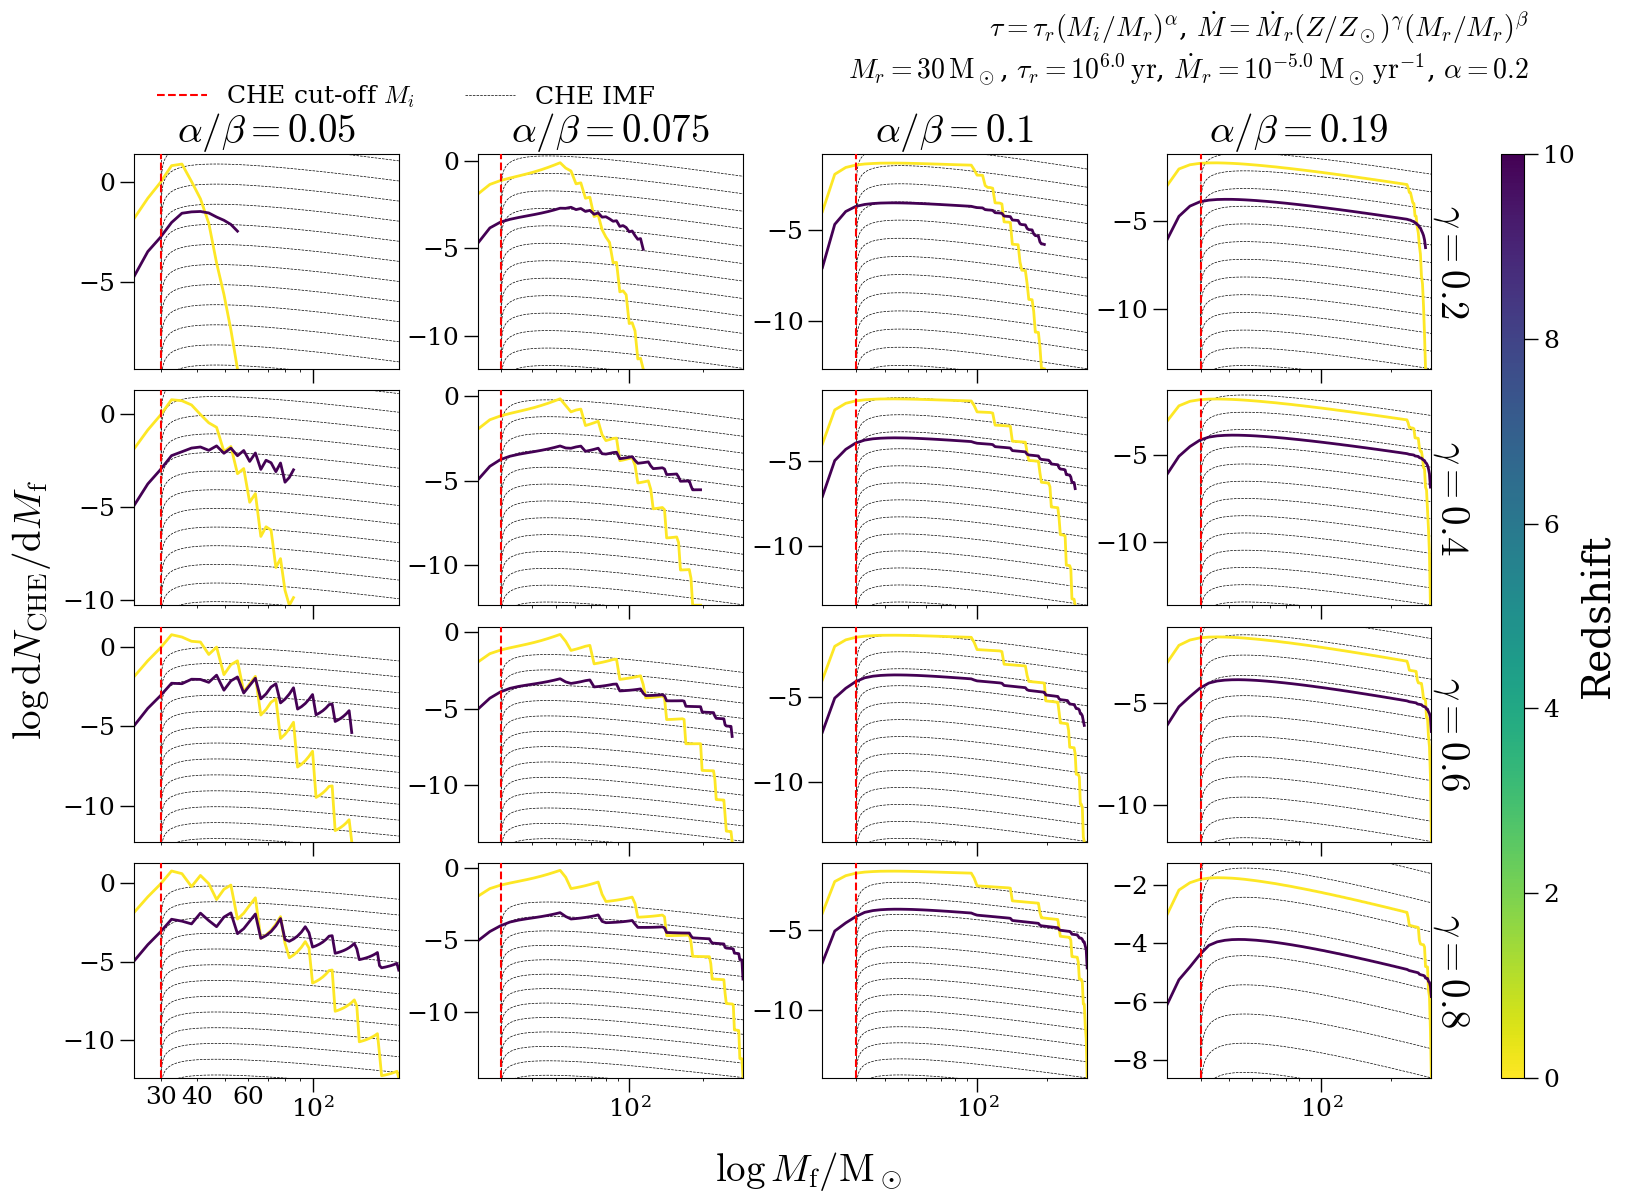

In [359]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.05, 0.075, 0.1, 0.19]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 10) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 10.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)
che_max_Z = 0.1*Z_SUN # assumed maximum metallciity for CHE

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -np.inf
abs_max_y = np.inf
x_log_scale = True

save = False
fname = 'sv20winds_dnche_dmf_prediction'

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args,
                max_logZ=np.log(che_max_Z)
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 12, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

if save:
    savefig(fig, fname)

CPU times: user 23.3 s, sys: 99.7 ms, total: 23.4 s
Wall time: 23.4 s


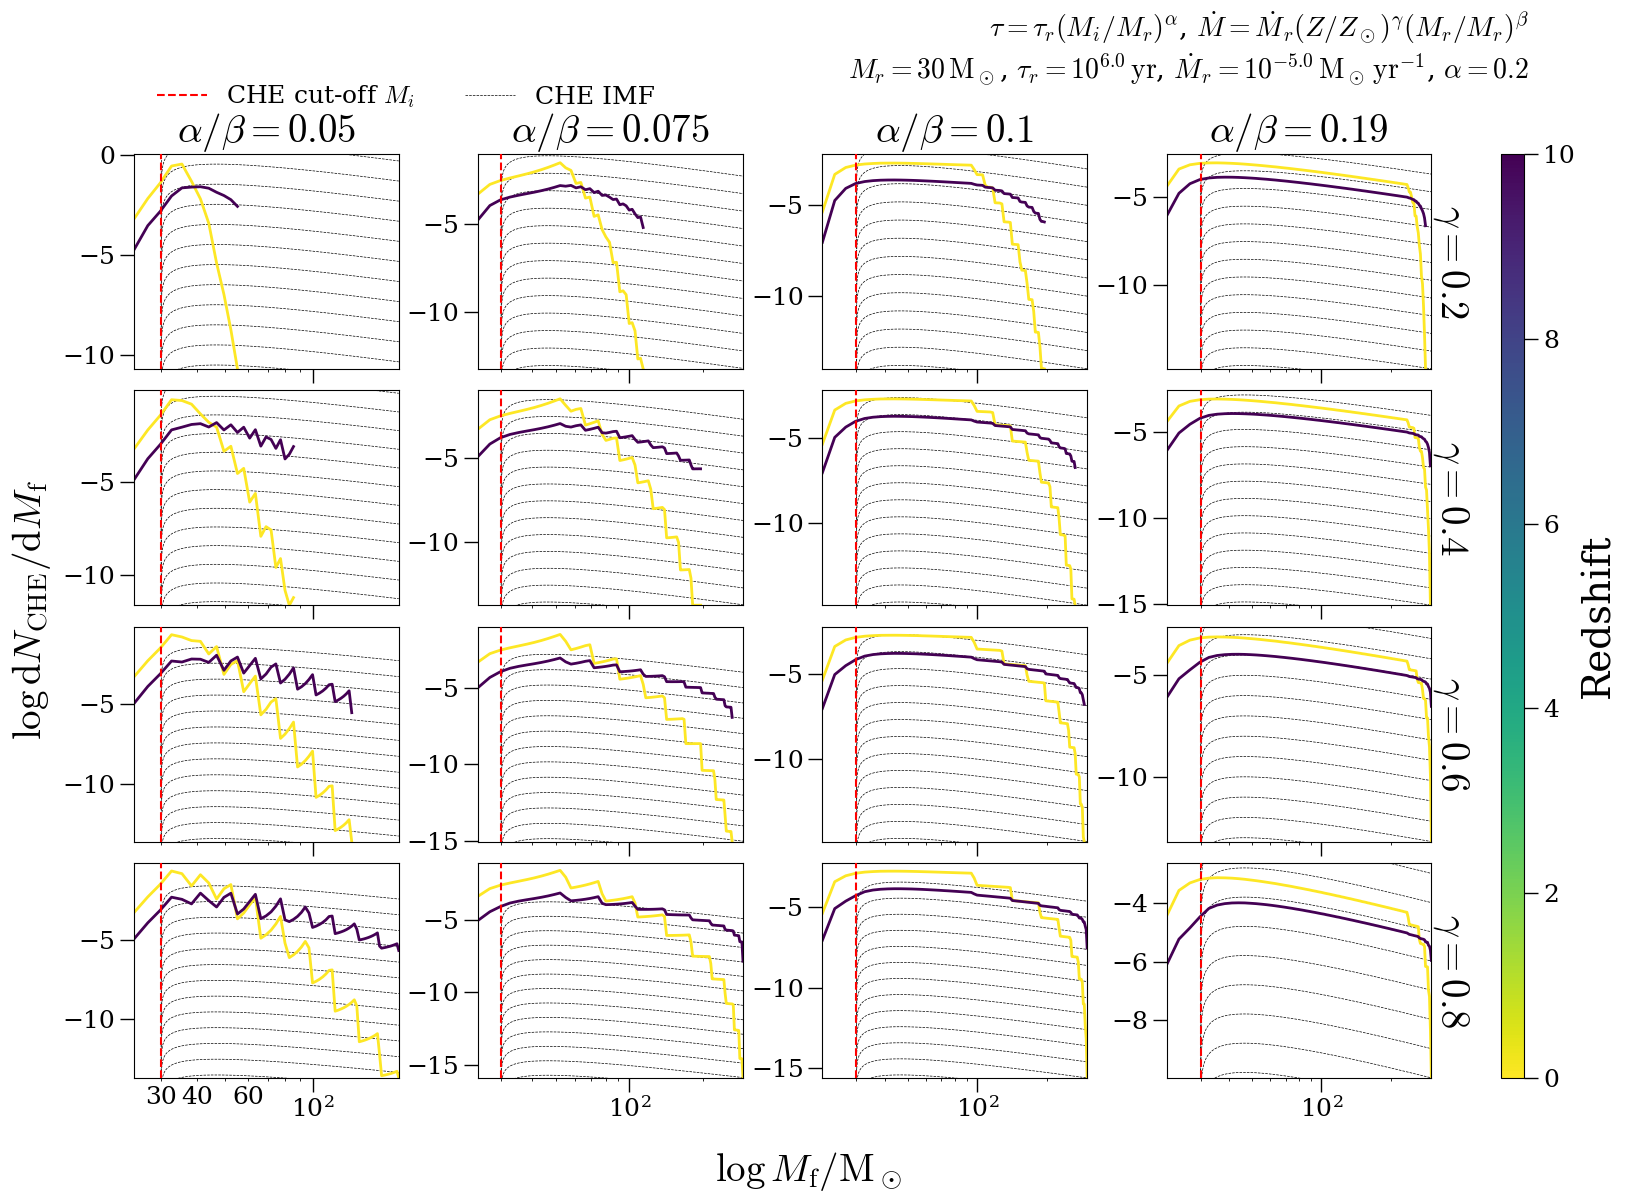

In [360]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.05, 0.075, 0.1, 0.19]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 10) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 10.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)
che_max_Z = 0.4*Z_SUN # assumed maximum metallciity for CHE

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -np.inf
abs_max_y = np.inf
x_log_scale = True

save = False
fname = 'sv20winds_dnche_dmf_prediction'

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args,
                max_logZ=np.log(che_max_Z)
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 12, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

if save:
    savefig(fig, fname)

CPU times: user 23.1 s, sys: 95.7 ms, total: 23.2 s
Wall time: 23.2 s


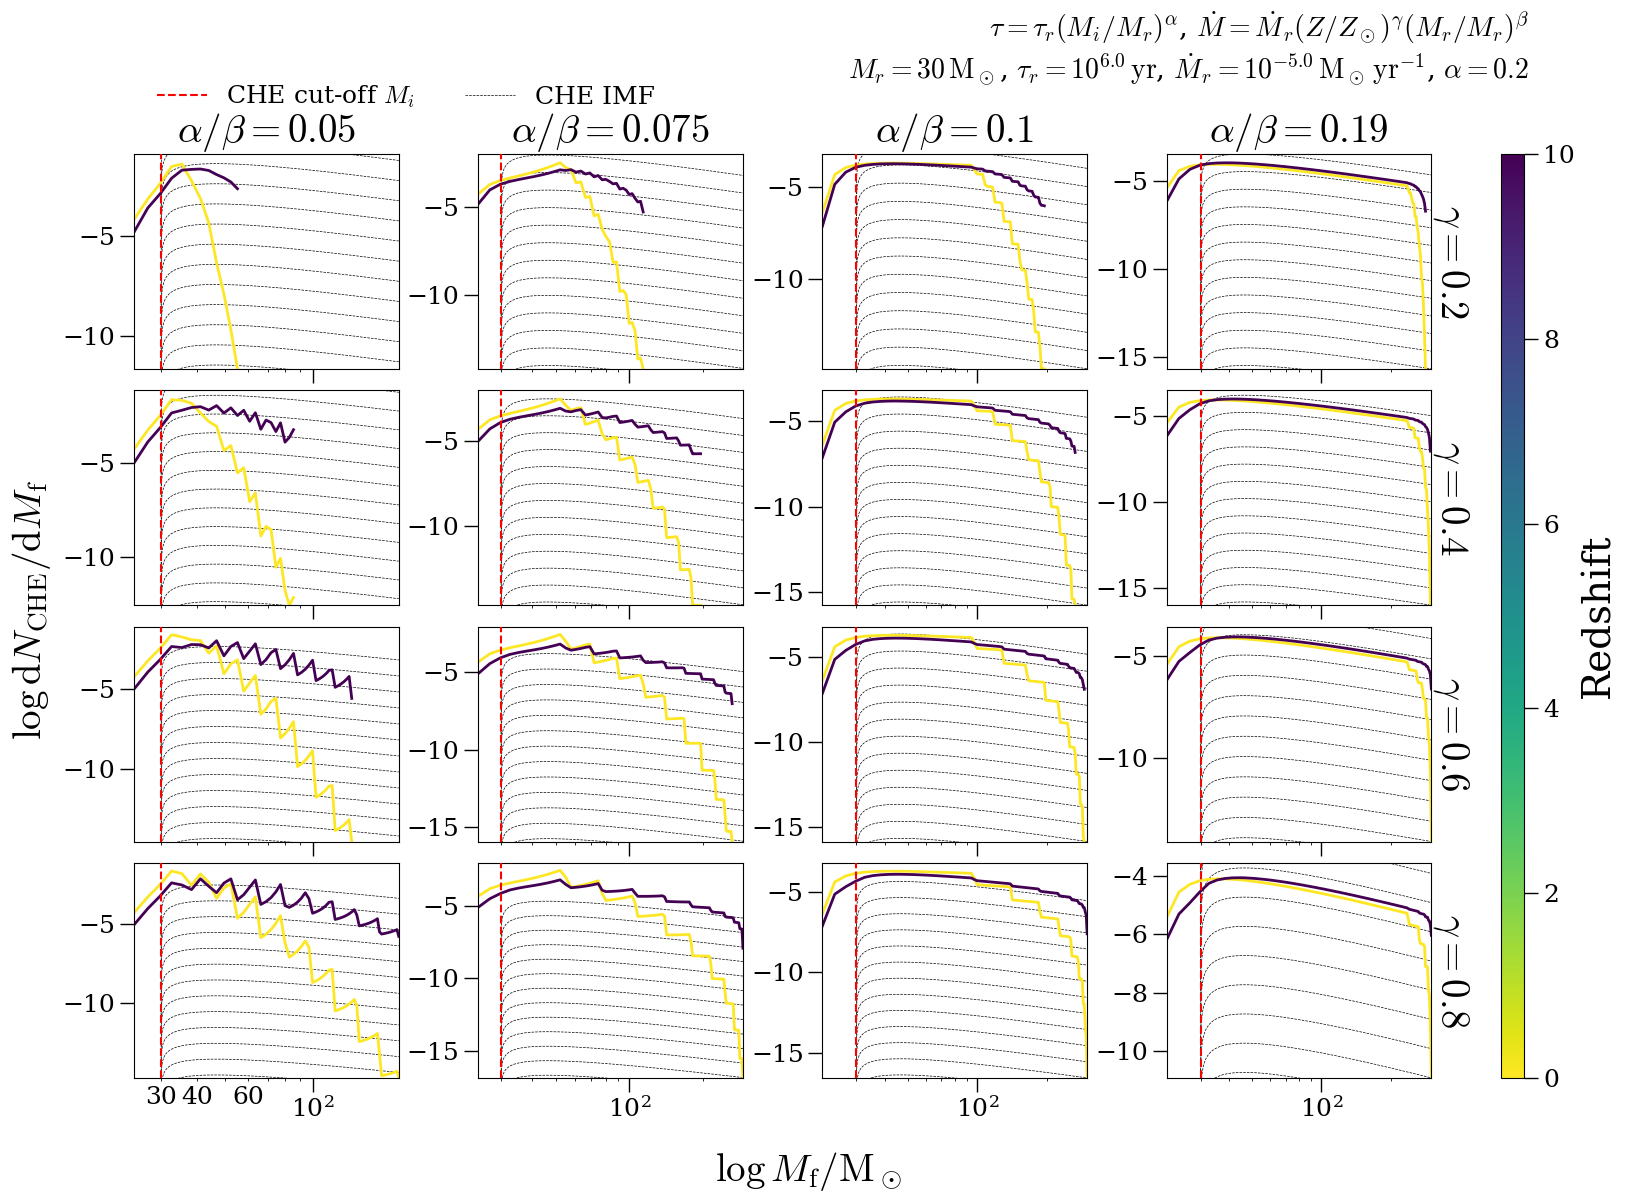

In [365]:
%%time

# PLOT SETTINGS
## Plot variables
m_i_min = 10 # minimum mass to sample (Msun)
m_i_max = 300 # maximum mass to sample (Msun)
m_i_size = 10000 # number of masses to sample
alpha_div_beta_arr = np.array([0.05, 0.075, 0.1, 0.19]) # varies over axes vertically
Z_arr = np.logspace(-3, 0, 10) * Z_SUN # variations within one axis, color-coded
gamma_arr = np.arange(0.2, 1.0, 0.2) # varies over axes horizontally
redshift_arr = np.arange(0., 11., 10.)

## Reference/normalization
M_r = 30 # reference mass (Msun)
tau_r = 1e6 # approximate lifetime of a star with mass M_r (yr)
Mdot_r = 1e-5 # approximate mass-loss rate at 0.1Zsun for a star with mass M_r (Msun yr-1)
alpha = 0.2 # approximate value for the He star stage in CHE stars

## CHE window
che_m_min = 30 # minimum mass for CHE stars (Msun)
che_p_min = 0.4 # minimum period for CHE stars (d)
che_lower_slope = 0.002 # slope of the lower edge of the CHE window (d Msun-1)
che_upper_slope = 0.01 # slope of the upper edge of the CHE window (d Msun-1)
che_max_Z = 1. # assumed maximum metallciity for CHE

## Plot settings
figsize = (18, 12)
cmap = cm.viridis_r
wspace = 0.3
hspace = 0.1
sharex = 'col'
sharey = False
y_padding = 0.5 # add to upper y-axis limit
# absolute limits, i.e., never allow ax limits to go outside these values
abs_min_x = -np.inf
abs_max_x = np.inf
abs_min_y = -np.inf
abs_max_y = np.inf
x_log_scale = True

save = False
fname = 'sv20winds_dnche_dmf_prediction'

##################
# PLOT
fig, axes = plt.subplots(
    len(gamma_arr), 
    len(alpha_div_beta_arr), 
    figsize=figsize,
    sharex=sharex, 
    sharey=sharey
    )
fig.subplots_adjust(wspace=wspace, hspace=hspace)

m_i_arr = np.linspace(m_i_min, m_i_max, m_i_size) # base for x axis (Msun)
log_z_arr = np.log10(Z_arr / Z_SUN)  # log metallicity for titles
che_args = (che_m_min, che_p_min, che_lower_slope, che_upper_slope)

# axis limit array
ax_xmax_arr = np.ones(axes.shape) * -np.inf
ax_xmin_arr = np.ones(axes.shape) * np.inf
ax_ymax_arr = np.ones(axes.shape) * -np.inf
ax_ymin_arr = np.ones(axes.shape) * np.inf
ax_lim_arr = np.stack((ax_xmin_arr, ax_xmax_arr, ax_ymin_arr, ax_ymax_arr))

for i, gamma in enumerate(gamma_arr):
    
    for j, alpha_div_beta in enumerate(alpha_div_beta_arr):
        ax = axes[i, j]
        
        for redshift in redshift_arr:
            x_arr, y_arr = metallicity_convolve(
                redshift_arr=np.array([redshift]),
                m_i_arr=m_i_arr,
                Mdot_r=Mdot_r,
                Z_arr=Z_arr,
                alpha=alpha,
                alpha_div_beta=alpha_div_beta,
                gamma=gamma,
                M_r=M_r,
                tau_r=tau_r,
                che_args=che_args,
                max_logZ=np.log(che_max_Z)
            )
            c = cmap((redshift - redshift_arr.min()) / (redshift_arr.max() - redshift_arr.min()))
            
            ax.plot(x_arr, y_arr, c=c)
            
            # update limits
            ax_lim_arr[0, i, j] = np.min((ax_lim_arr[0, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[1, i, j] = np.max((ax_lim_arr[1, i, j], x_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))
            ax_lim_arr[2, i, j] = np.min((ax_lim_arr[2, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].min()))
            ax_lim_arr[3, i, j] = np.max((ax_lim_arr[3, i, j], y_arr[~np.isnan(x_arr) & ~np.isnan(y_arr)].max()))

        # label rows
        if j == axes.shape[1] - 1:
            ax.text(1, 0.5, f'$\\gamma={gamma:.1f}$', rotation=-90, ha='left', va='center', transform=ax.transAxes)
        # label columns
        if i == 0:
            ax.set_title(f'$\\alpha/\\beta={alpha_div_beta}$')  
    
# set shared limits, if any
if sharex:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[0, i, j] = ax_lim_arr[0, i, j].min()
        ax_lim_arr[1, i, j] = ax_lim_arr[1, i, j].max()
elif sharex == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[0, :, j] = ax_lim_arr[0, :, j].min()
        ax_lim_arr[1, :, j] = ax_lim_arr[1, :, j].max()
elif sharex == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[0, i, :] = ax_lim_arr[0, i, :].min()
        ax_lim_arr[1, i, :] = ax_lim_arr[1, i, :].max()
elif not sharex:
    pass
else:
    raise ValueError(f'Invalid sharex value: {sharex}')

if sharey:
    for i, j in np.ndindex(axes.shape):
        ax_lim_arr[2, i, j] = ax_lim_arr[2, i, j].min()
        ax_lim_arr[3, i, j] = ax_lim_arr[3, i, j].max()
elif sharey == 'col':
    for j in range(axes.shape[1]):
        ax_lim_arr[2, :, j] = ax_lim_arr[2, :, j].min()
        ax_lim_arr[3, :, j] = ax_lim_arr[3, :, j].max()
elif sharey == 'row':
    for i in range(axes.shape[0]):
        ax_lim_arr[2, i, :] = ax_lim_arr[2, i, :].min()
        ax_lim_arr[3, i, :] = ax_lim_arr[3, i, :].max()
elif not sharey:
    pass
else:
    raise ValueError(f'Invalid sharey value: {sharey}')

# Plot visual guides
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    
    # Minimimum CHE M_i
    ax.vlines(
        che_m_min,
        ax_lim_arr[2, i, j], 
        ax_lim_arr[3, i, j]+y_padding, 
        ls='--', color='r', lw=1.5, zorder=3
    )
    
    # CHE IMF
    ref_i = -1
    x_arr = np.linspace(0.1, m_i_max, m_i_size)
    mpeak = x_arr[ref_i]
    # normalize to lower y limit
    y_arr = safe_log10(
        dnche_dmi(x_arr, *che_args)
        / dnche_dmi(mpeak, *che_args)
        * 10.**ax_lim_arr[2, i, j]
    )
    for shift in np.arange(-5, 12, 1):
        ax.plot(x_arr, y_arr+shift, 'k--', lw=0.5, zorder=0)

# set limits
for i, j in np.ndindex(axes.shape):
    ax = axes[i, j]
    ax.set_xlim(
        np.max((ax_lim_arr[0, i, j], abs_min_x)), 
        np.min((ax_lim_arr[1, i, j], abs_max_x))
        )
    ax.set_ylim(
        np.max((ax_lim_arr[2, i, j], abs_min_y)),
        np.min((ax_lim_arr[3, i, j], abs_max_y)) + y_padding
    )
    
    if x_log_scale:
        ax.set_xscale('log')
    
############################
            
# ax ticks and labels
fig.text(0.08, 0.5, '$\\log\mathrm{d}N_\\mathrm{CHE}/\mathrm{d}M_\\mathrm{f}$', rotation=90, ha='right', va='center', transform=fig.transFigure)

if x_log_scale:
    for ax in axes.ravel():
        set_log_x_with_minor_format(ax)
        # get rid of scientific notation on x-axis for minor ticks
        #minor_ticks = ax.xaxis.get_minor_ticks()
        #if any(tick.tick1line.get_visible() or tick.tick2line.get_visible() for tick in minor_ticks):
        #minor_tick_labels = [tick.label1.get_text() for tick in minor_ticks]
        #if any(label for label in minor_tick_labels):
        #    formatter = ScalarFormatter()
        #    formatter.set_scientific(False)
        #    formatter.set_useOffset(False)
        #    ax.xaxis.set_minor_formatter(formatter)
    x_label = '$\\log M_\\mathrm{f}/\\mathrm{M}_\\odot$'
else:
    x_label = '$M_\\mathrm{f}/\\mathrm{M}_\\odot$'
fig.text(0.5, 0.05, x_label, rotation=0, ha='center', va='top', transform=fig.transFigure)

# COLORBAR
sm = cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=redshift_arr.min(), vmax=redshift_arr.max()))
cb = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.05, aspect=40)
cb.set_label('Redshift')
    
# LEGEND
handles = [
    ax.plot([], [], 'r--', label='CHE cut-off $M_i$', lw=1.5)[0],
    ax.plot([], [], 'k--', label='CHE IMF', lw=0.5)[0],
]
axes[0,0].legend(handles=handles, loc='lower left', bbox_to_anchor=(0, 1.1), frameon=False, fontsize=18, ncol=2)

# DESCRIPTION
descr = '\n'.join((
    '$\\tau = \\tau_r (M_i/M_r)^\\alpha$, $\\dot{M} = \\dot{M}_r (Z/Z_\odot)^\\gamma(M_r/M_r)^\\beta$',
    f'$M_r={M_r}\\,\\mathrm{{M}}_\\odot$, $\\tau_r=10^{{{np.log10(tau_r):.1f}}}\\,\\mathrm{{yr}}$, $\\dot{{M}}_r=10^{{{np.log10(Mdot_r):.1f}}}\\,\\mathrm{{M}}_\\odot\\,\\mathrm{{yr}}^{{-1}}$, $\\alpha=0.2$',  
))
fig.text(0.9, 1, descr, fontsize=20, ha='right', va='top', transform=fig.transFigure)

if save:
    savefig(fig, fname)